# All libraries used

In [457]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 
import datetime as dt

import klib as kb
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from pymoo.optimize import minimize
from pymoo.factory import get_termination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Analyze Description

- Import data

In [458]:
df = pd.read_csv("../data/edited_horse_racing_data.csv", encoding="latin1").drop(columns="Unnamed: 0")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267221 entries, 0 to 267220
Data columns (total 51 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   race_id              267221 non-null  int64  
 1   runner_id            267221 non-null  int64  
 2   meeting_date         267221 non-null  object 
 3   course               267221 non-null  object 
 4   race_time            267221 non-null  object 
 5   race_timestamp       267221 non-null  object 
 6   name                 267221 non-null  object 
 7   b_rank               265708 non-null  float64
 8   m_rank               267221 non-null  float64
 9   rank_diff            267221 non-null  float64
 10  my_odds              265708 non-null  float64
 11  early_price          250422 non-null  float64
 12  value                250422 non-null  float64
 13  m_type               267221 non-null  object 
 14  race_type            267221 non-null  object 
 15  bet_type         

- Data Missing

Let's generate a table to check the percentage of missing data

In [459]:
def table_missing(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False) * 100
    missing = pd.concat([total, percent], axis=1, join="outer", keys=["total_missing", "percentage"])
    missing.index.name = "features Numerics"
    return missing

In [460]:
table_missing(df)

,total_missing,percentage
features Numerics,,
horse_equip,171056,64.012933
off_rating,113390,42.433042
ew_places,54318,20.326995
ew_rules,54318,20.326995
bsp_place,23316,8.725362
isp,22109,8.273676
bsp_win,22105,8.272179
lenghts_behind,22101,8.270682
race_going,22101,8.270682


*Nullity matrix:* Is a data-dense display which lets you quickly visually pick out patterns in data completion.

<Axes: >

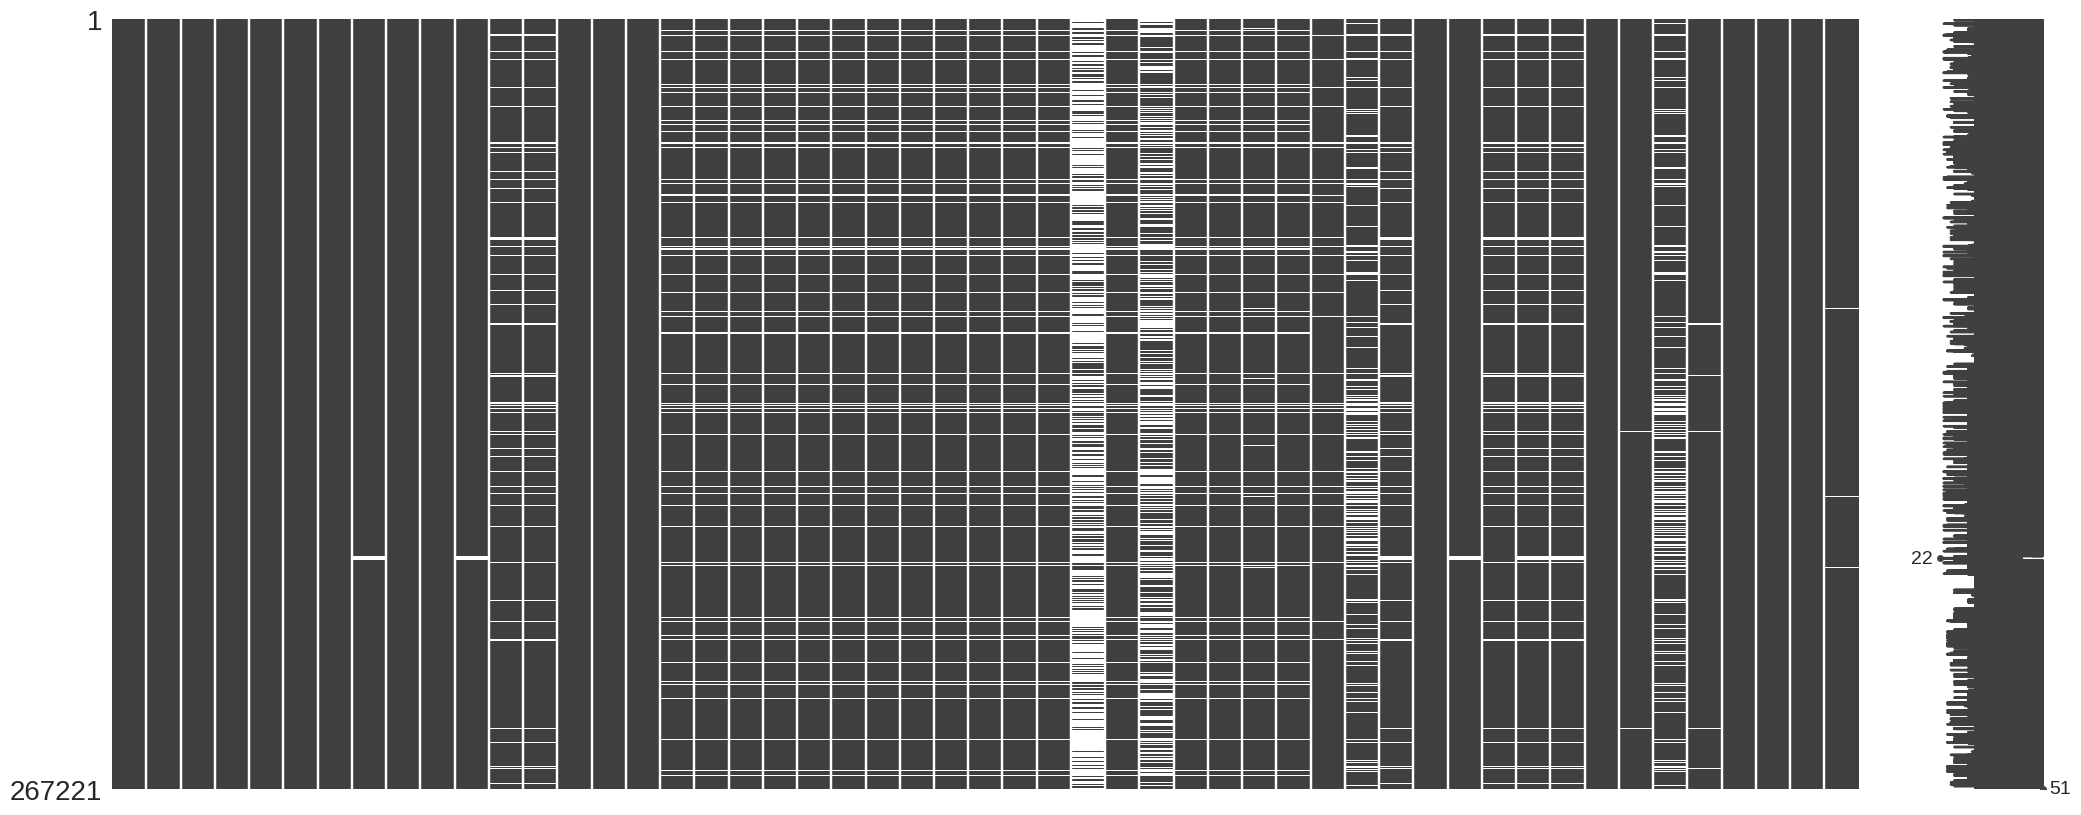

In [461]:
msno.matrix(df)

### *Missingno correlation heatmap* 

Measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another

Subtitle:

- The null correlation ranges from -1 to 0
- Null correlation ranges from -1 (if one variable looks like the other definitely doesn't show up)
- If it is 0 (variables appearing or not appearing have no effect on each other)
- If it is 1 (if one variable appears, the other definitely also influences the other)
- Entries marked <1or > -1 have a correlation close to being exactly negative or positive.

<Axes: >

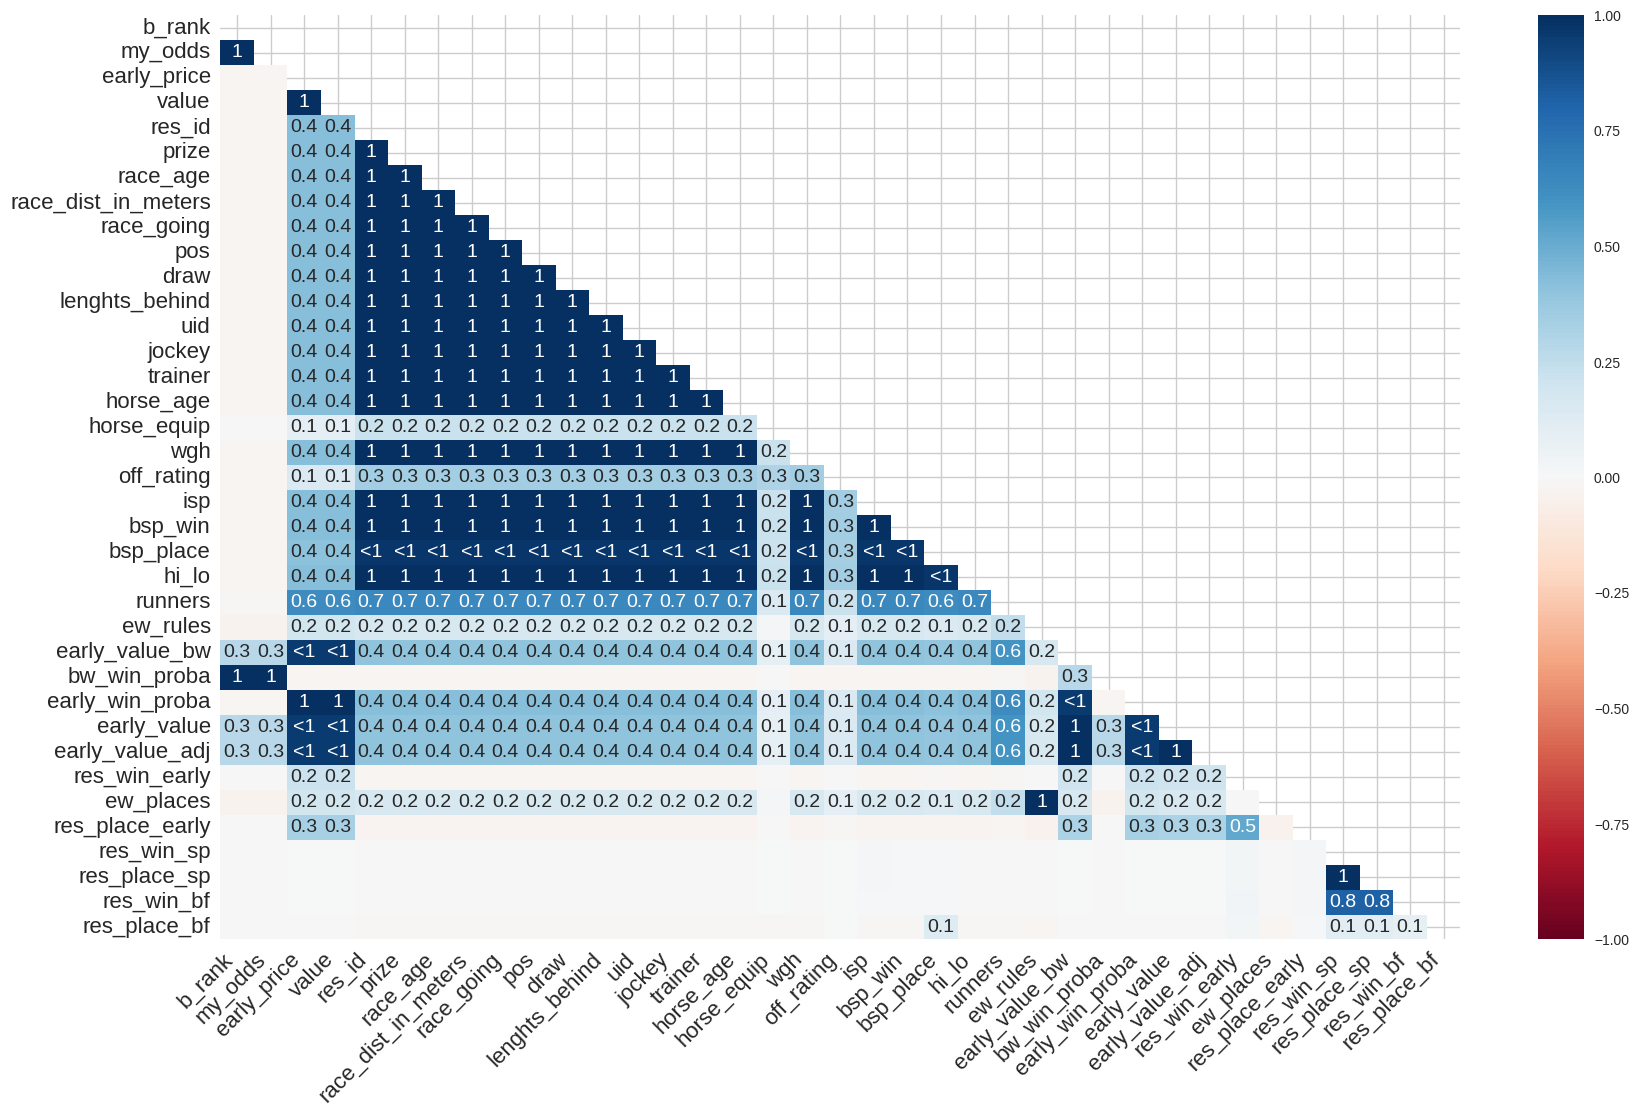

In [462]:
msno.heatmap(df)

### *Dendrogram*
The dendrogram allows you to more fully correlate variable completion, revealing trends deeper than the pairwise ones visible in the correlation heatmap:

The dendrogram is a tree diagram that shows the groups formed by grouping observations at each step and their similarity levels. The similarity level is measured along the vertical axis (alternatively, you can display the distance level) and different observations are specific along the horizontal axis.

Interpretation
Use the dendrogram to visualize how clusters are formed at each step and to evaluate the levels of similarity (or distance) of the clusters that are formed.

To display similarity (or distance) levels, hold the pointer over a horizontal line in the dendrogram. The pattern of how similarity or distance values ​​change from one step to another can help you choose the final grouping of your data. The step where the values ​​change abruptly can identify a good point to define the final grouping.

The decision on the final grouping is also called cutting the dendrogram. Trimming the dendrogram is similar to drawing a line across the entire dendrogram to specify the final grouping. You can also compare dendrograms to different final groupings to determine which final grouping makes the most sense for the data.

<Axes: >

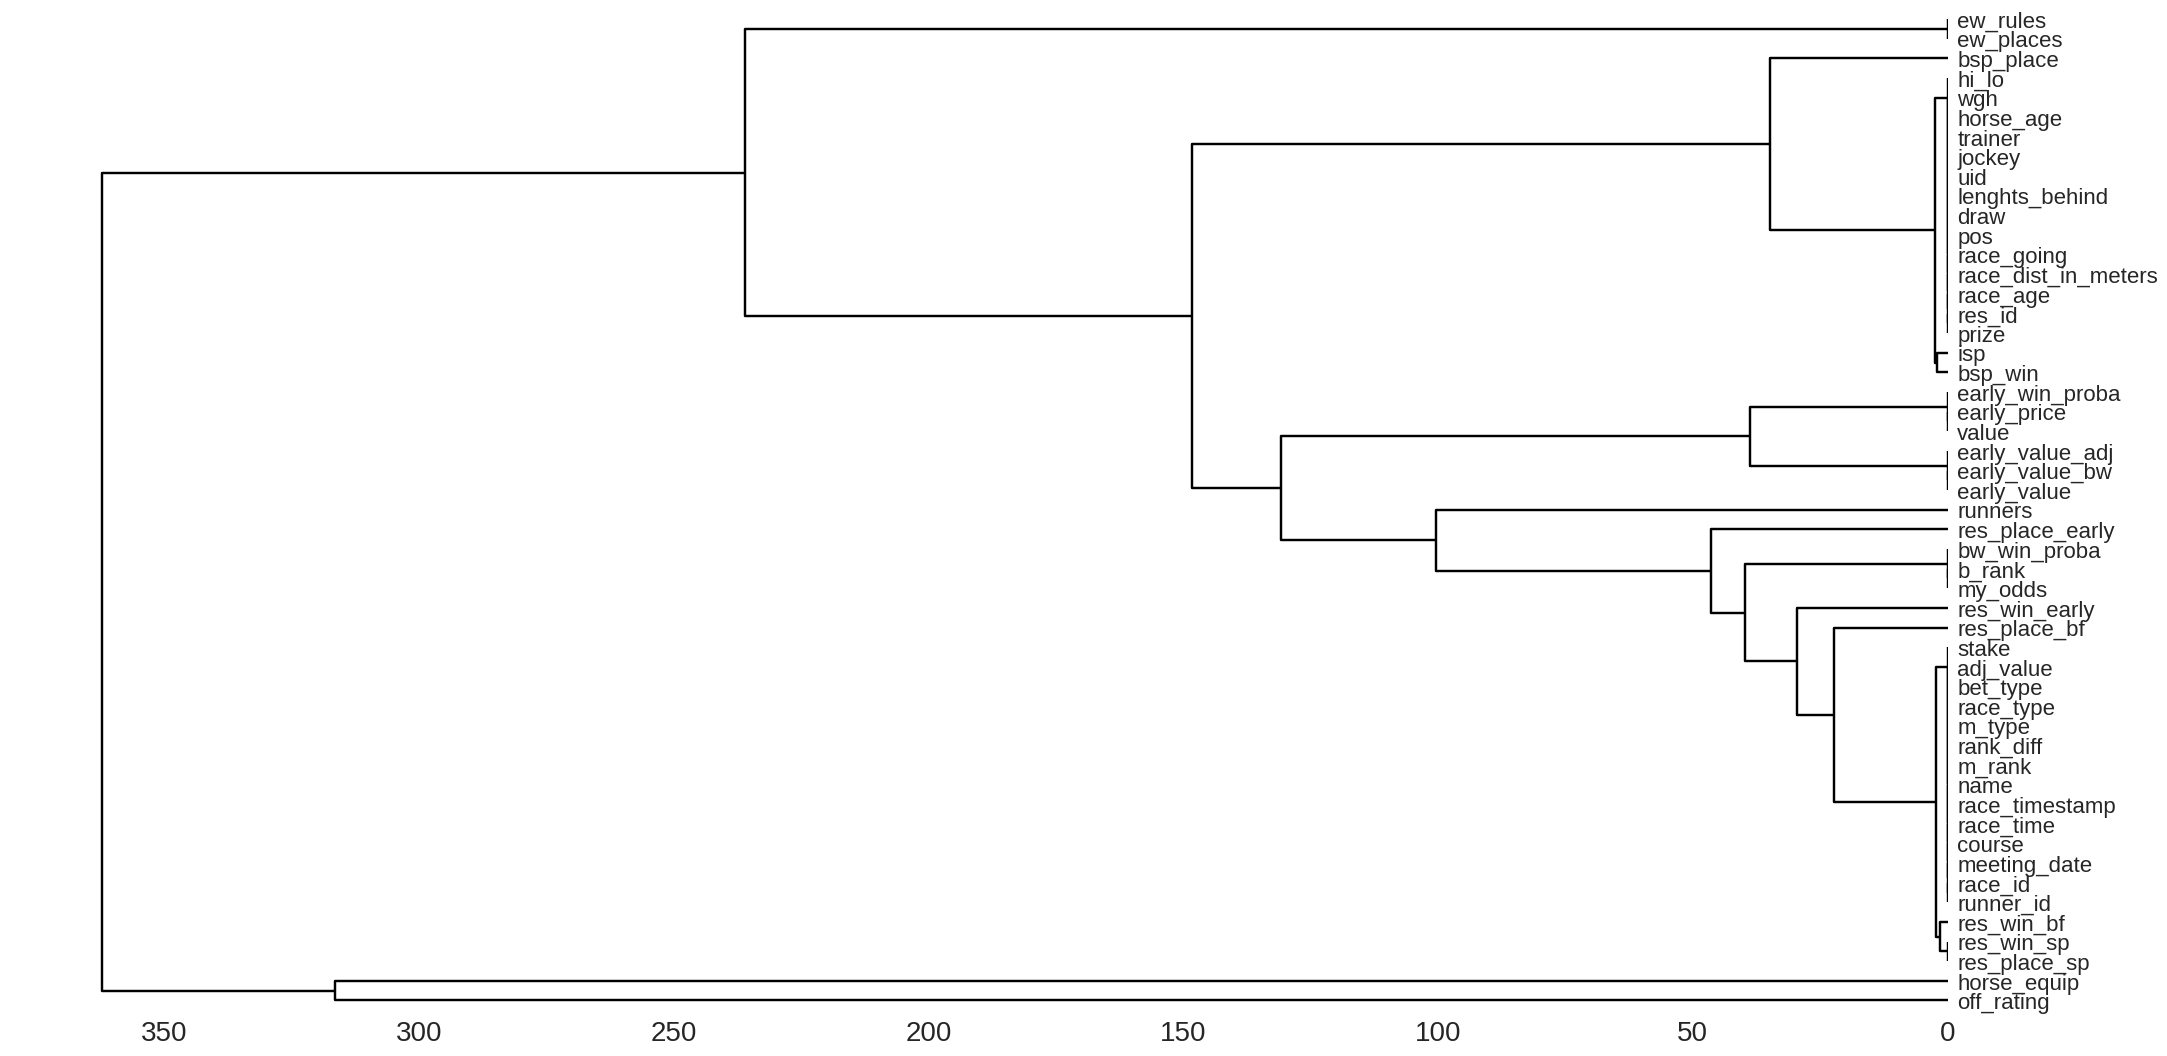

In [463]:
msno.dendrogram(df)

# Exploratory Data Analysis

## Identify areas where your probabilities are more accurate

Histogram of Odds (my_odds):

This histogram will show the distribution of the probabilities that you modeled. It can help you identify areas where your probabilities are more accurate.

<Axes: xlabel='my_odds', ylabel='Count'>

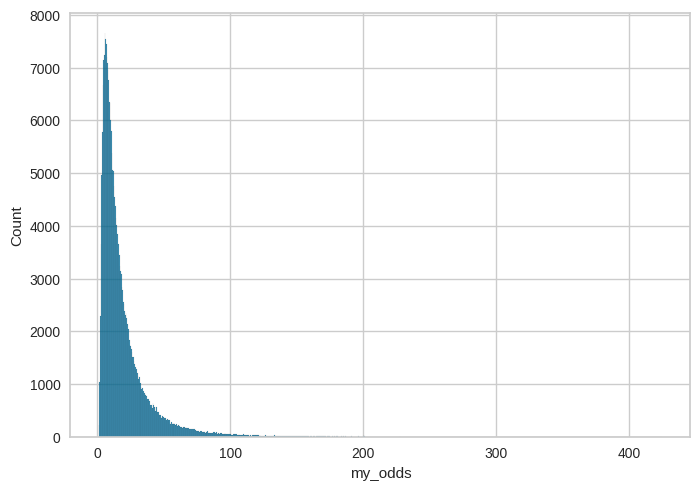

In [464]:
sns.histplot(data=df, x="my_odds")

To find an area where your probability is more precise, we can follow the following steps:

1. Calculate the forecast errors: First, you will need to calculate the forecast errors by comparing your probabilities (my_odds) with the actual results (for example, res_win_sp)


In [465]:
df['prediction_error'] = df['my_odds'] - df['res_win_sp']

2. *Histogram Analysis:* When examining the histogram, you can look for areas where prediction errors are more concentrated around zero. This would indicate that your probabilities are closer to the actual results in those cases, in other words, more accurate.

- If the peak of the histogram is close to zero, it suggests that your probabilities are accurate in that range.

- If there is a leftward skew (larger negative values), your probabilities may be conservative (underestimating the chances of winning).

- If there is a rightward skew (larger positive values), your probabilities may be optimistic (overestimating the chances of winning).

- Histogram analysis will help identify areas where your probabilities perform better, enabling you to take actions to improve the model in areas where predictions are less accurate.

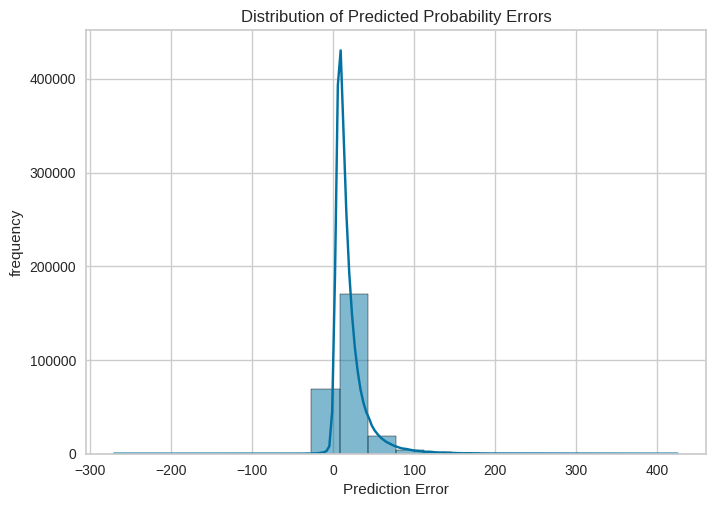

In [466]:
sns.histplot(data=df, x="prediction_error", bins=20, kde=True)
plt.xlabel('Prediction Error')
plt.ylabel('frequency')
plt.title('Distribution of Predicted Probability Errors')
plt.show()

We can then make a filter to paste prediction_error between 0 and 30 (Choose to adjust the interval according to your interpretation of the histogram). Com isso é possivel mazer inferences e colher cavalos

In [467]:
df.query("prediction_error > 0 and prediction_error < 30")

,race_id,runner_id,meeting_date,course,race_time,race_timestamp,name,b_rank,m_rank,rank_diff,...,early_value_adj,stake,res_win_early,ew_places,res_place_early,res_win_sp,res_place_sp,res_win_bf,res_place_bf,prediction_error
0,1112839,2346844,2022-4-07,aintree,13:45,45:00.0,pic dorhy,1.0,3.0,2.0,...,4.75,1,-1.0,1.0,-1.0,-1.0,-1.0,-1.00,1.86,4.43
1,1112839,2479417,2022-4-07,aintree,13:45,45:00.0,gin on lime,2.0,4.0,2.0,...,2.75,1,-1.0,1.0,-1.0,-1.0,-1.0,-1.00,-1.00,4.64
2,1112839,2519123,2022-4-07,aintree,13:45,45:00.0,erne river,3.0,1.0,-2.0,...,-16.25,1,-1.0,1.0,-1.0,-1.0,-1.0,-1.00,1.14,7.72
3,1112839,2421600,2022-4-07,aintree,13:45,45:00.0,millers bank,4.0,5.0,1.0,...,-5.25,1,7.4,1.0,-1.0,7.0,-1.0,8.17,2.49,2.23
4,1112839,2450183,2022-4-07,aintree,13:45,45:00.0,war lord,5.0,2.0,-3.0,...,-14.25,1,-1.0,1.0,-1.0,-1.0,-1.0,-1.00,-1.00,10.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267212,1246816,3991578,2023-7-29,york,17:45,45:00.0,mr squires,9.0,9.5,0.5,...,-3.25,1,-1.0,3.0,-1.0,-1.0,-1.0,-1.00,-1.00,21.72
267213,1246816,3916375,2023-7-29,york,17:45,45:00.0,maharajas express,10.0,7.0,-3.0,...,-7.25,1,-1.0,3.0,-1.0,-1.0,-1.0,-1.00,-1.00,22.86
267214,1246816,3899874,2023-7-29,york,17:45,45:00.0,reginald charles,11.0,15.0,4.0,...,-2.25,1,-1.0,3.0,9.4,-1.0,5.6,-1.00,7.20,24.53
267215,1246816,3942925,2023-7-29,york,17:45,45:00.0,b associates,12.0,9.5,-2.5,...,-4.25,1,-1.0,3.0,-1.0,-1.0,-1.0,-1.00,-1.00,27.84


## Analyze on top of net profit

To calculate the net profit based on the data you provided, you can use the SP price (Starting Price) and SP result (res_win_sp) information. Net income can be calculated as follows:

1. First, you need to create a column that represents the gross profit for each horse in each race. This can be calculated by subtracting the SP price (res_win_sp) from the starting price (early_price):

In [468]:
df['gross_profit'] = df['early_price'] - df['res_win_sp']


2. Next, you can create a column for net income. Remember that net income can be positive
(if the horse wins) or negative (if the horse loses). So you can create a column that is equal to profit
raw if the horse wins (res_win_sp is greater than 0) and zero otherwise:

In this code, `where` is used to apply the condition. If `res_win_sp` is greater than zero, the `net_profit` column will have the value of `gross_profit`, otherwise it will be zero.
Now the `net_profit` column will represent the net profit for each horse in each race.

In [469]:
df['net_profit'] = df['gross_profit'].where(df['res_win_sp'] > 0,0)

- Bar plot race_type x net_profit :


1. Suppose you have a DataFrame df with the data and column 'net_profit'

2. Make sure 'race_type' is a column describing the type of race

3. If necessary, you can calculate average net profit instead of total using 'mean' instead of 'sum'

In [470]:
profit_by_race_type = df.groupby('race_type')['net_profit'].sum().reset_index()

As you can see the jump type races are the most profitable and the least profitable are the aw

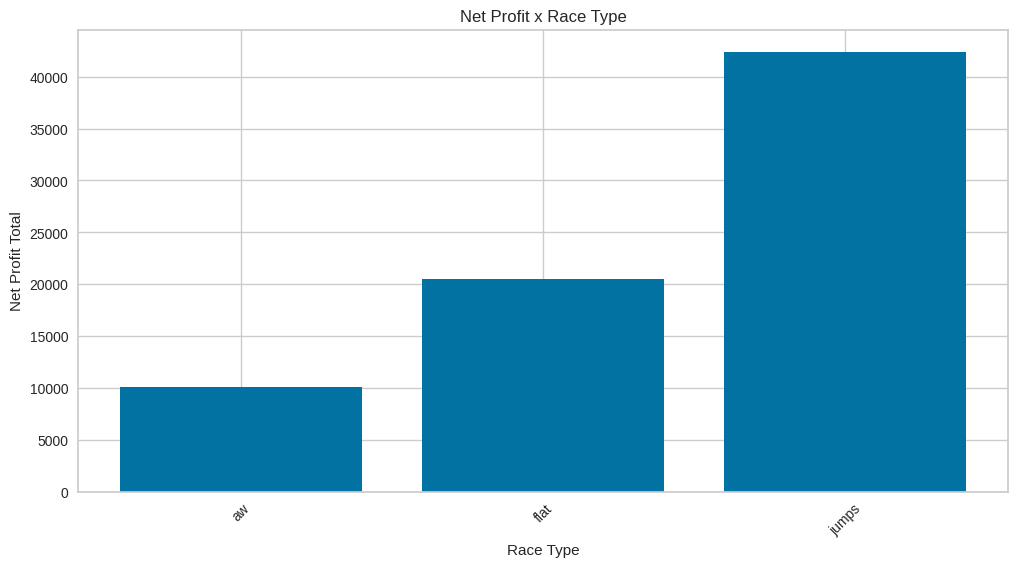

In [471]:
plt.figure(figsize=(12, 6))
plt.bar(profit_by_race_type['race_type'], profit_by_race_type['net_profit'])
plt.xlabel('Race Type')
plt.ylabel('Net Profit Total')
plt.title('Net Profit x Race Type')
plt.xticks(rotation=45)  
plt.show()

- Top 10 max race type jumps net profit 

In [472]:
df.query('race_type == "jumps" ').nlargest(10, "net_profit")

,race_id,runner_id,meeting_date,course,race_time,race_timestamp,name,b_rank,m_rank,rank_diff,...,res_win_early,ew_places,res_place_early,res_win_sp,res_place_sp,res_win_bf,res_place_bf,prediction_error,gross_profit,net_profit
122857,1190914,3943211,2022-12-30,taunton,12:45,45:00.0,inspiratrice,9.0,13.5,4.5,...,999.0,NaN,-1.00,200.0,-1.0,755.08,-1.00,-158.90,800.0,800.0
175952,1190914,3943211,2022-12-30,taunton,12:45,45:00.0,inspiratrice,9.0,13.5,4.5,...,999.0,NaN,-1.00,200.0,-1.0,755.08,-1.00,-159.24,800.0,800.0
105775,1126348,3820474,2022-5-24,punchestown,13:20,20:00.0,sawbuck,9.0,22.0,13.0,...,999.0,4.0,199.80,300.0,60.0,999.00,78.74,-270.80,700.0,700.0
169792,1126348,3820474,2022-5-24,punchestown,13:20,20:00.0,sawbuck,14.0,22.0,8.0,...,999.0,4.0,199.80,300.0,60.0,999.00,78.74,-260.83,700.0,700.0
120944,1180460,2177143,2022-11-22,southwell,13:05,05:00.0,moroval,7.0,7.0,0.0,...,369.0,1.0,-1.00,100.0,-1.0,189.00,41.00,-67.92,270.0,270.0
174357,1180460,2177143,2022-11-22,southwell,13:05,05:00.0,moroval,7.0,7.0,0.0,...,369.0,1.0,-1.00,100.0,-1.0,189.00,41.00,-66.12,270.0,270.0
184775,1199328,2430101,2023-2-02,wincanton,14:30,30:00.0,calgary tiger,6.0,6.0,0.0,...,169.0,2.0,42.25,50.0,12.5,73.41,20.32,-30.69,120.0,120.0
192590,1199328,2430101,2023-2-02,wincanton,14:30,30:00.0,calgary tiger,6.0,6.0,0.0,...,169.0,2.0,42.25,50.0,12.5,73.41,20.32,-26.00,120.0,120.0
184929,1208062,3929320,2023-3-09,wincanton,14:05,05:00.0,stopherandgo,8.0,8.0,0.0,...,139.0,NaN,-1.00,40.0,-1.0,116.75,-1.00,-10.38,100.0,100.0
192745,1208062,3929320,2023-3-09,wincanton,14:05,05:00.0,stopherandgo,9.0,8.0,-1.0,...,139.0,NaN,-1.00,40.0,-1.0,116.75,-1.00,-3.75,100.0,100.0


# Creating features of time 

We created some timing resources to assist with future analysis

In [473]:
df["meeting_date"] = pd.to_datetime(df["meeting_date"])
df["year"] = df["meeting_date"].dt.year
df["quarter"] = df["meeting_date"].dt.quarter
df["month"] = df["meeting_date"].dt.month

In [474]:
race_period = []
for t in df.race_time:
    if t >= '18:00':
        race_period.append('18:00-21:00')
    elif t >'15:30' and t < '18:00':
        race_period.append('15:31-18:00')
    elif t <= '15:30':
        race_period.append('11:20-15:30')
    else:
        print("Error")
        
df["race_period"] = race_period

# Scatterplot

- Gráfico de Dispersão (Early_Price vs. Early_Win_Proba):

This chart can help identify if there is any correlation between starting odds and winning odds. This can be helpful in understanding how the market values ​​horses. We noticed that the higher the early_win_proba, the lower the early_price

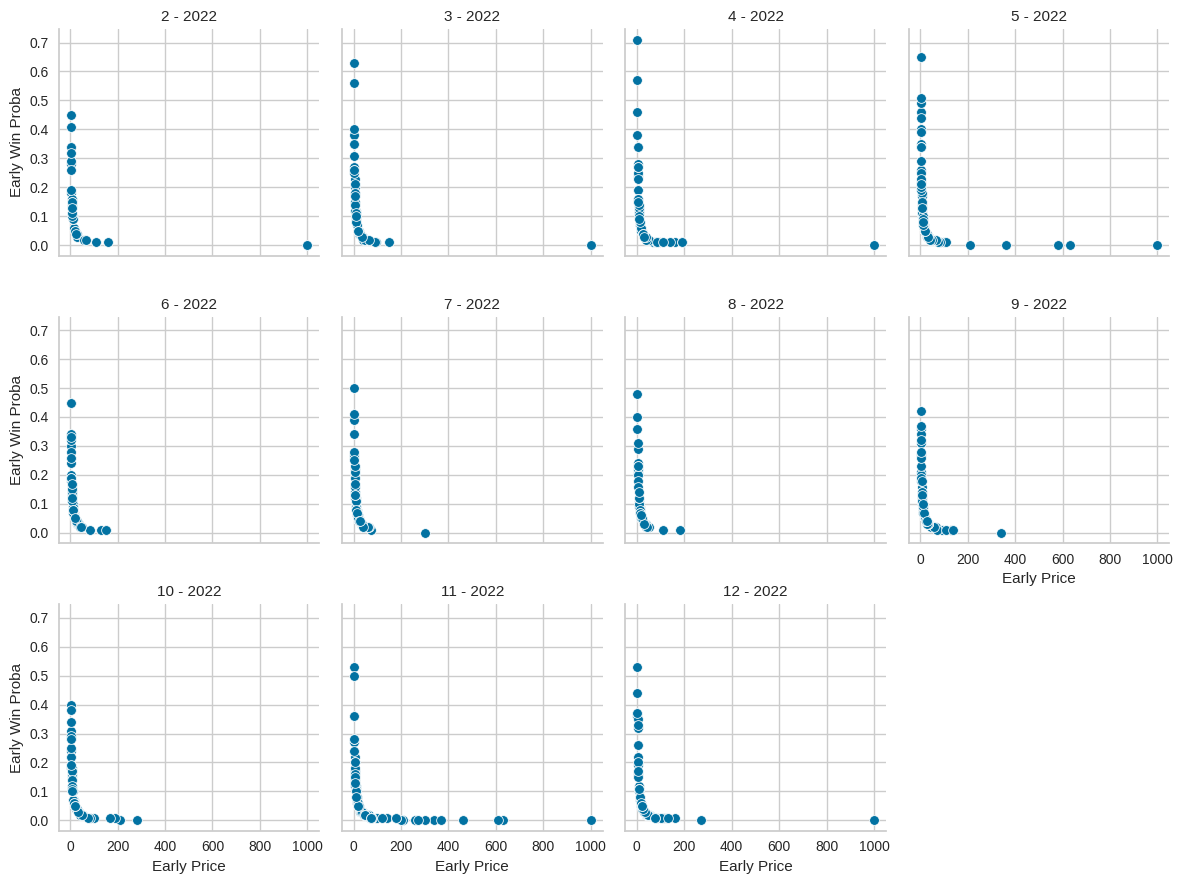

In [475]:
# Create a FacetGrid based on your filtered DataFrame
g = sns.FacetGrid(df.query("year == 2022").sample(n=1000), col="month", col_wrap=4)

# Map the scatterplot to each facet with transparency (alpha) and jitter
g.map(sns.scatterplot,"early_price", "early_win_proba")

# Adjust axis labels and other customization elements if necessary
g.set_axis_labels("Early Price", "Early Win Proba")
g.set_titles(col_template="{col_name} - 2022")
plt.show()

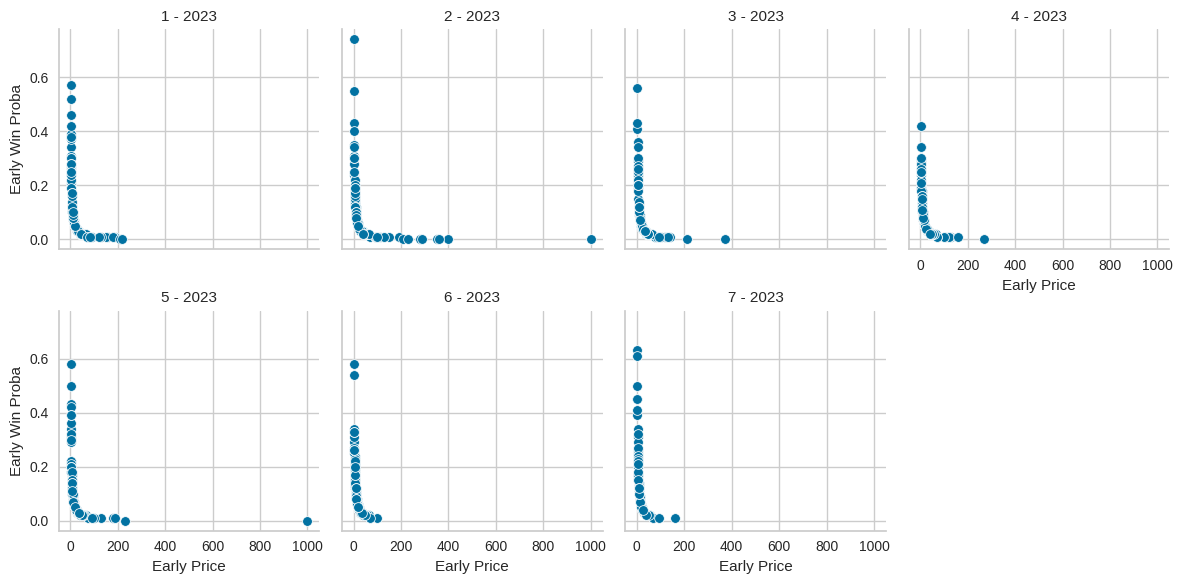

In [476]:
g = sns.FacetGrid(df.query("year == 2023").sample(n=1000), col="month", col_wrap=4)
g.map(sns.scatterplot,"early_price", "early_win_proba")

g.set_axis_labels("Early Price", "Early Win Proba")
g.set_titles(col_template="{col_name} - 2023")
plt.show()

- Early_Price x Bsp_Win

This chart can help identify how starting prices compare to Betfair win prices. This can be helpful in understanding how the market moves relative to initial prices. Realize that the initial prices are directly proportional and very dense at the lowest values

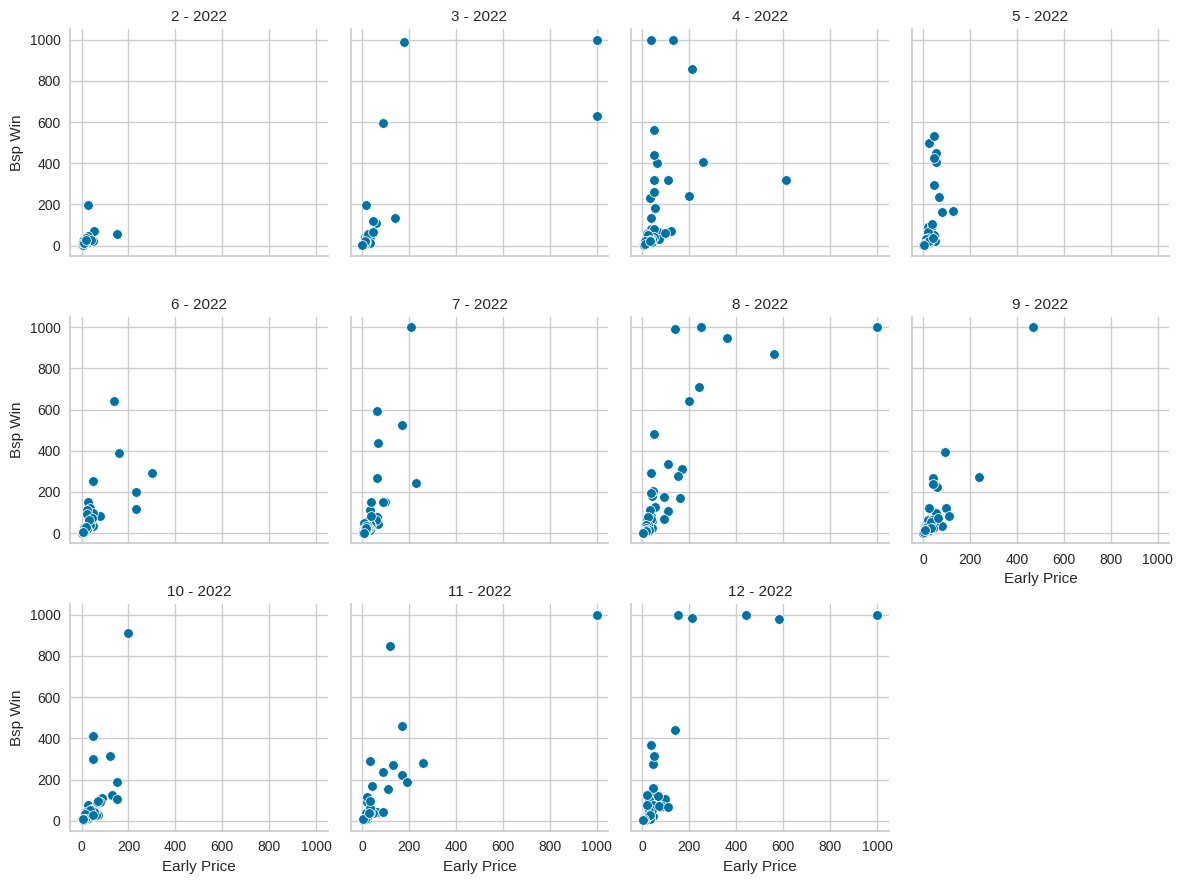

In [477]:
g = sns.FacetGrid(df.query("year == 2022").sample(n=1000), col="month", col_wrap=4)
g.map(sns.scatterplot,"early_price",  "bsp_win")

g.set_axis_labels("Early Price", "Bsp Win")
g.set_titles(col_template="{col_name} - 2022")
plt.show()

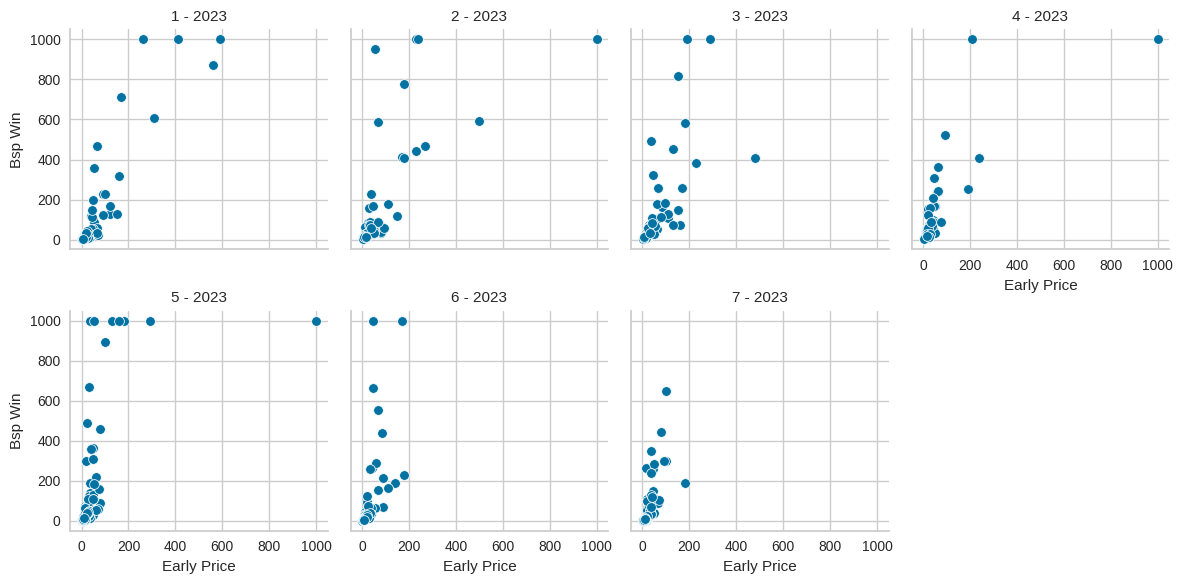

In [478]:
g = sns.FacetGrid(df.query("year == 2023").sample(n=1000), col="month", col_wrap=4)
g.map(sns.scatterplot,"early_price",  "bsp_win")

g.set_axis_labels("Early Price", "Bsp Win")
g.set_titles(col_template="{col_name} - 2023")
plt.show()

- My odds x Horse Age

The greatest odds are between 3 and 11 years

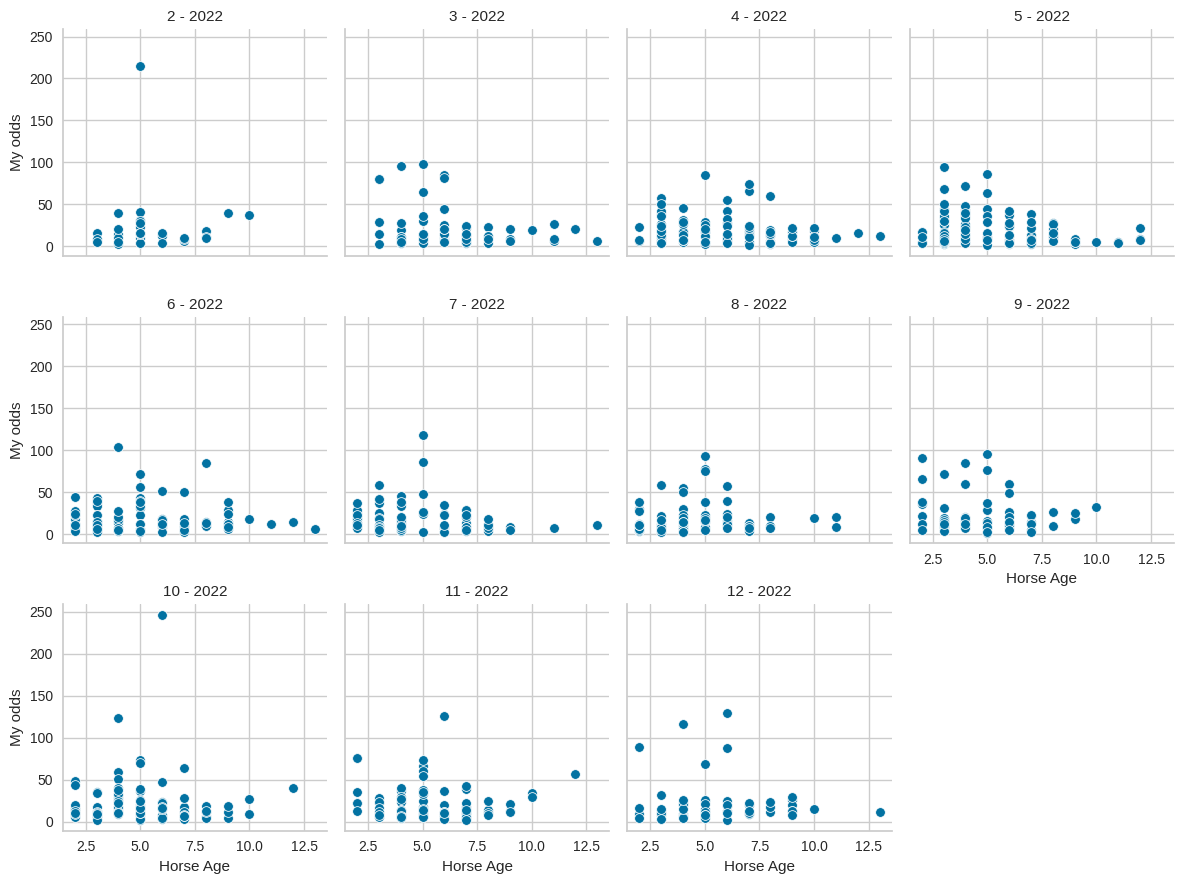

In [480]:
g = sns.FacetGrid(df.query("year == 2022 ").sample(n=1000), col="month", col_wrap=4)
g.map(sns.scatterplot,"horse_age",  "my_odds")

g.set_axis_labels("Horse Age", "My odds")
g.set_titles(col_template="{col_name} - 2022")
plt.show()

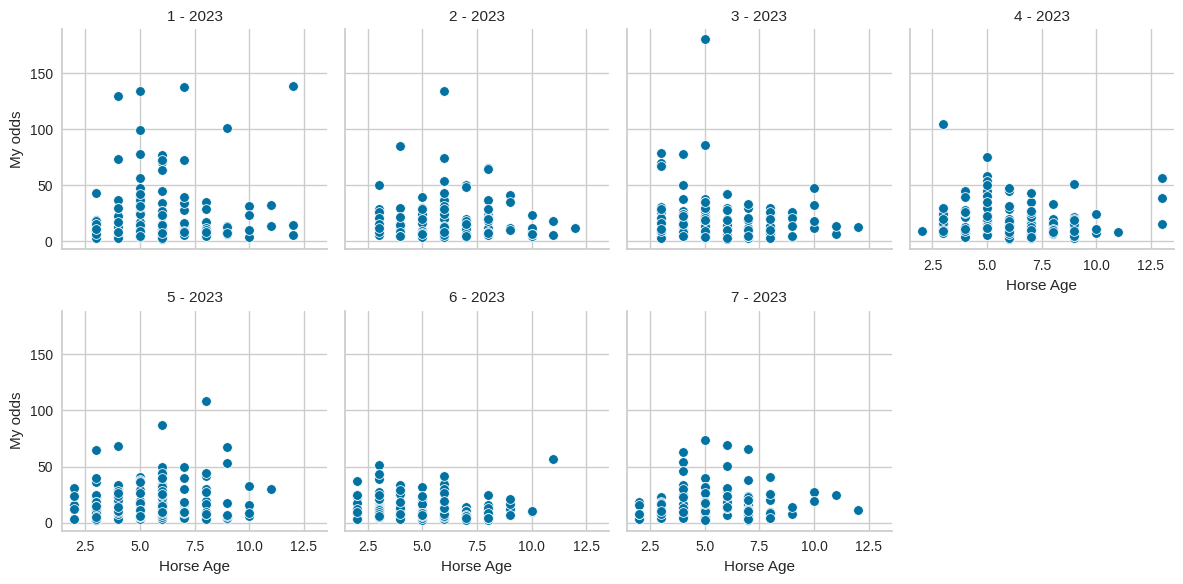

In [481]:
g = sns.FacetGrid(df.query("year == 2023").sample(n=1000), col="month", col_wrap=4)
g.map(sns.scatterplot,"horse_age",  "my_odds")

g.set_axis_labels("Horse Age", "My odds")
g.set_titles(col_template="{col_name} - 2023")
plt.show()


- My Odds x Early Price

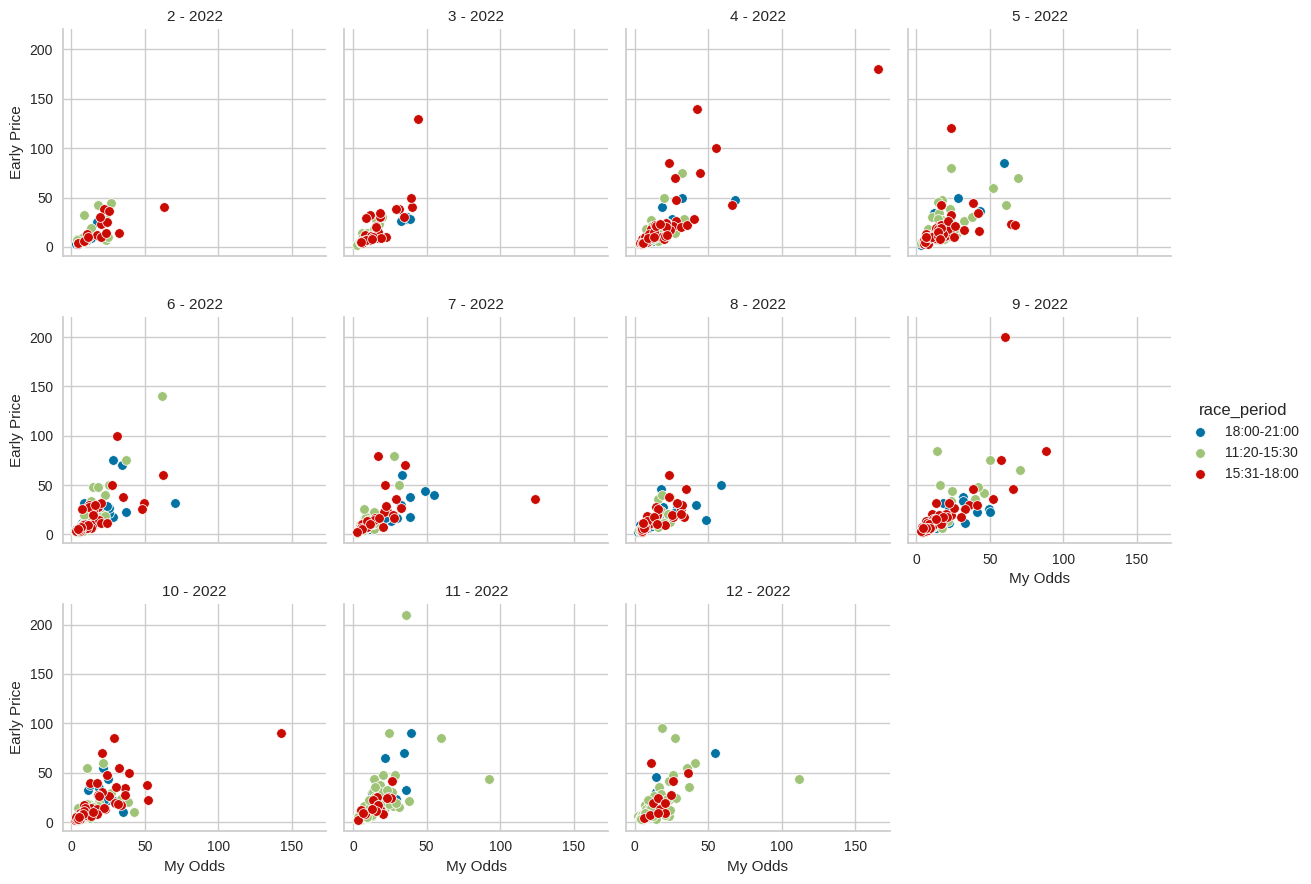

In [571]:
# Create a FacetGrid object
g = sns.FacetGrid(df.query("year == 2022").sample(n=1000), col="month", col_wrap=4, hue='race_period')

# Map the scatter plot with the data
g.map(sns.scatterplot, "my_odds", "early_price")

# Set x and y axis labels
g.set_axis_labels("My Odds", "Early Price")

# Set column titles
g.set_titles(col_template="{col_name} - 2022")

# Add caption for 'hue' parameter
g.add_legend()
plt.show()

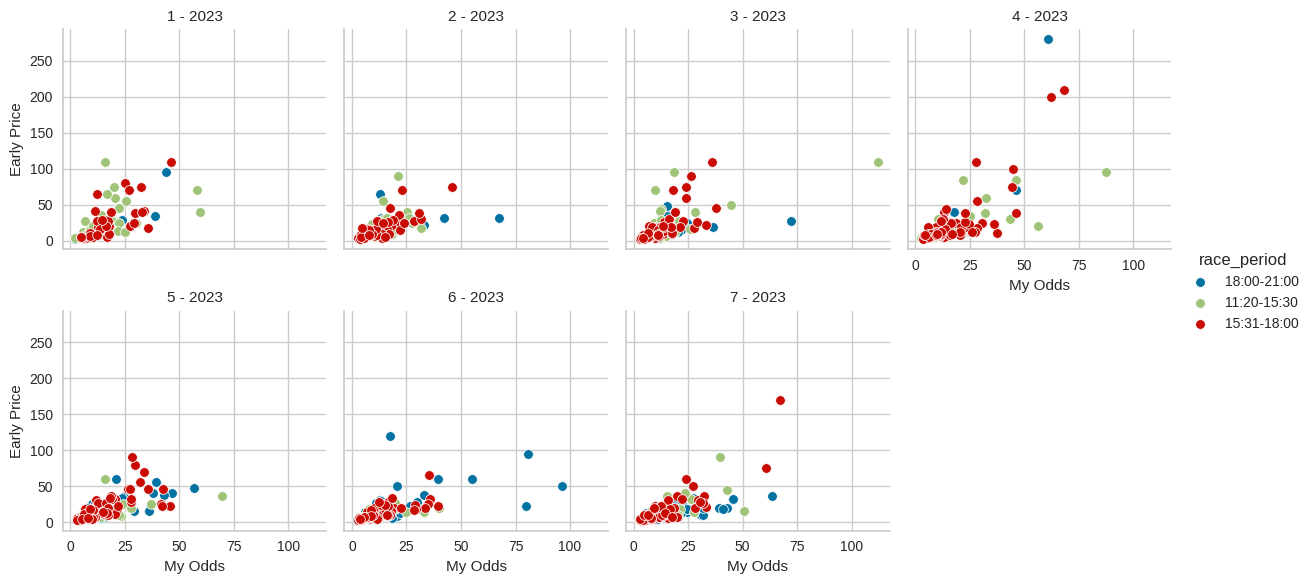

In [572]:
# Create a FacetGrid object
g = sns.FacetGrid(df.query("year == 2023").sample(n=1000), col="month", col_wrap=4, hue='race_period')

# Map the scatter plot with the data
g.map(sns.scatterplot, "my_odds", "early_price")

# Set x and y axis labels
g.set_axis_labels("My Odds", "Early Price")

# Set column titles
g.set_titles(col_template="{col_name} - 2023")

# Add caption for 'hue' parameter
g.add_legend()
plt.show()

## Boxplot

Text(0, 0.5, 'Pos')

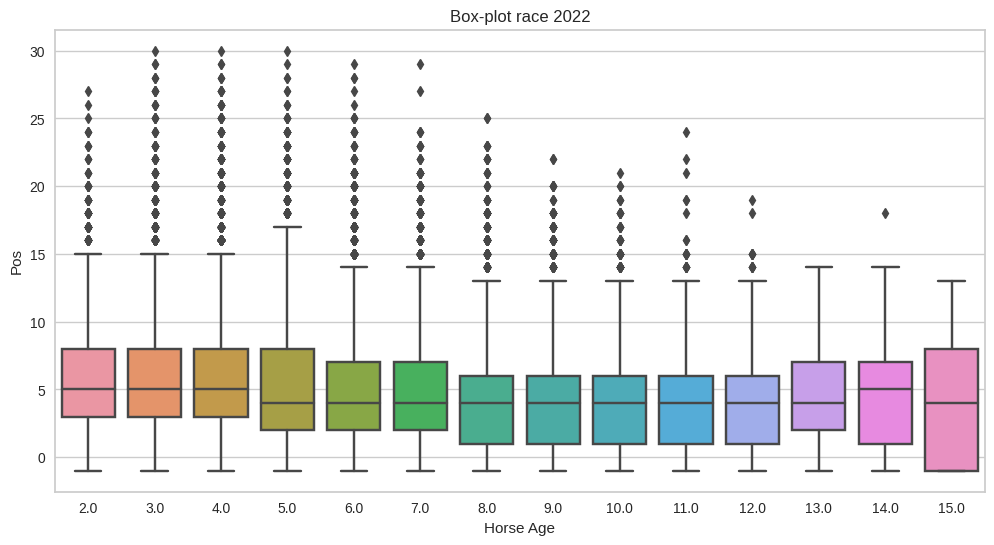

In [484]:
'''
Pos (Position of arrival) vs. Horse's age: This can help determine
whether the age of the horses is related to their finishing position.
And yes, older horses come in last position most of the time.
'''

plt.figure(figsize=(12, 6))
sns.boxplot(df.query("year == 2022 "), y="pos", x="horse_age")
plt.title("Box-plot race 2022")
plt.xlabel("Horse Age")
plt.ylabel("Pos")

Text(0, 0.5, 'Pos')

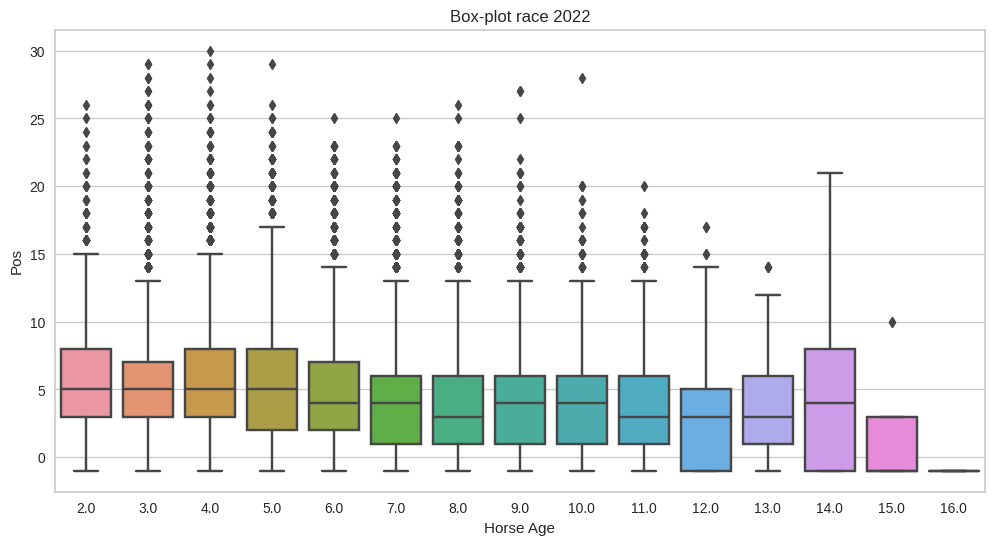

In [485]:
plt.figure(figsize=(12, 6))
sns.boxplot(df.query("year == 2023 "), y="pos", x="horse_age")
plt.title("Box-plot race 2022")
plt.xlabel("Horse Age")
plt.ylabel("Pos")

Text(0.5, 0, 'Race dist in meters')

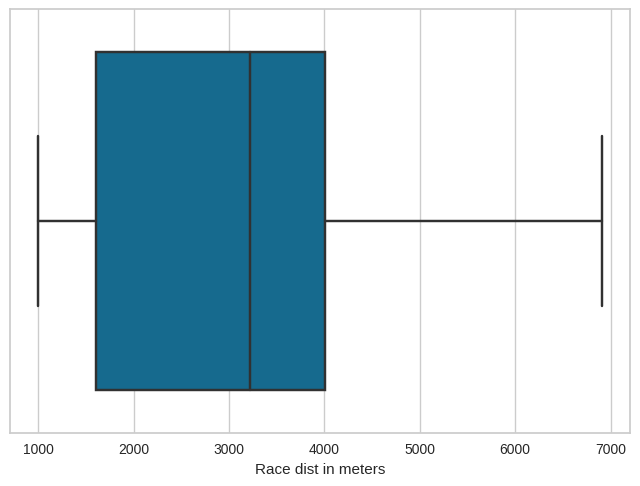

In [486]:
# distribution of race distances.
sns.boxplot(x=df["race_dist_in_meters"])
plt.xlabel("Race dist in meters")


Text(0.5, 0, 'Off Rating')

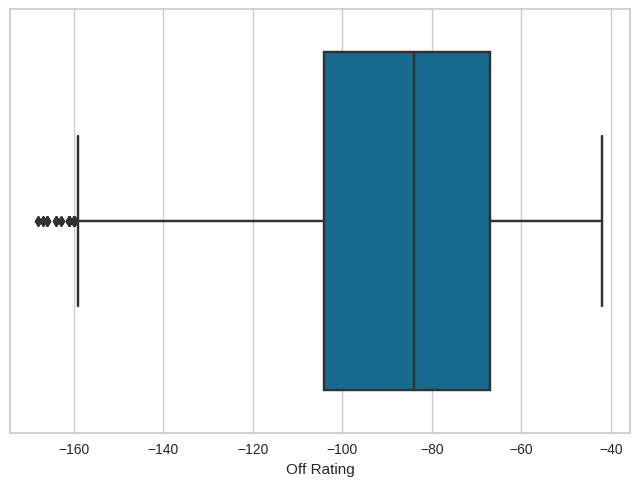

In [487]:
# A boxplot can be useful in understanding how horse rankings vary across races.
sns.boxplot(x=df["off_rating"])
plt.xlabel("Off Rating")

Text(0.5, 0, 'Horse Age')

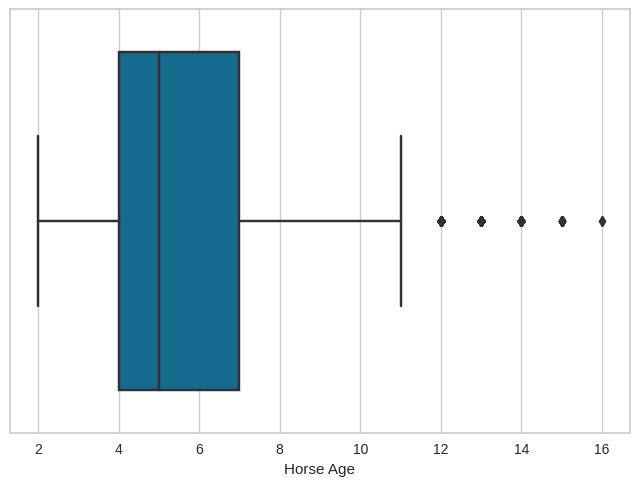

In [488]:
# Distribution of the ages of the horses.
sns.boxplot(x=df["horse_age"])
plt.xlabel("Horse Age")

# Horse winners

- Get number of winners by horse age?
Do you notice that horses over 10 years old are having fewer victories and horses under 3 years old are not very successful?

In [489]:
# 2022
df.query("res_win_early != -1 and year == 2022").horse_age.value_counts()

horse_age
5.0     3040
3.0     2703
6.0     2516
4.0     2360
7.0     1832
2.0     1364
8.0     1190
9.0      600
10.0     368
11.0     140
12.0      45
13.0      16
14.0       4
15.0       2
Name: count, dtype: int64

In [490]:
# 2023
df.query("res_win_early != -1 and year == 2023").horse_age.value_counts()

horse_age
6.0     2119
5.0     1757
3.0     1622
4.0     1307
7.0     1283
8.0      976
9.0      516
2.0      432
10.0     306
11.0     121
12.0      59
13.0      22
14.0       6
Name: count, dtype: int64

- Distribuit data age for sucessfull

We can see this by looking at the distribution of the data in the boxplot. It is clear that outilers, i.e. exceptions to the rule in which horses that are old enough for competition, have won

Text(0.5, 0, 'Horse Age')

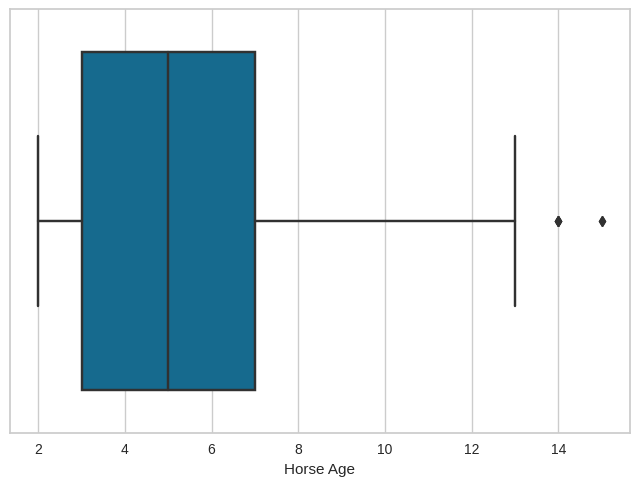

In [491]:
sns.boxplot(x=df.query("res_win_early != -1 and year == 2022")["horse_age"])
plt.xlabel("Horse Age")

Text(0.5, 0, 'Horse Age')

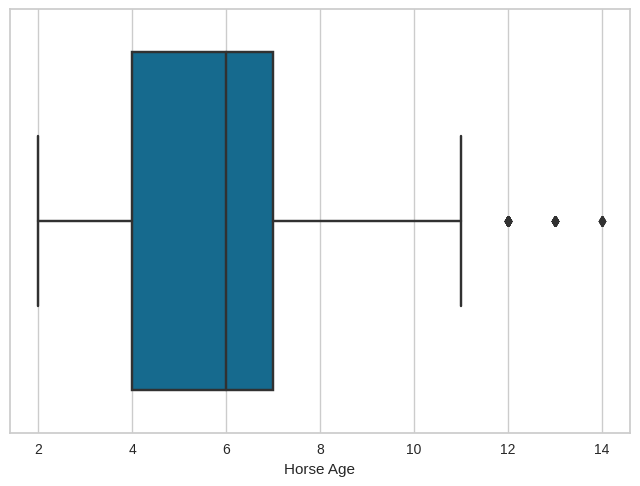

In [492]:
sns.boxplot(x=df.query("res_win_early != -1 and year == 2023")["horse_age"])
plt.xlabel("Horse Age")

Scatter that represents how the probability of winning varies according to age for each month, over the years.

Notice that horses with ages considered young and physically mature for the race had a greater chance of winning. This proves that they are relevant features to analyze

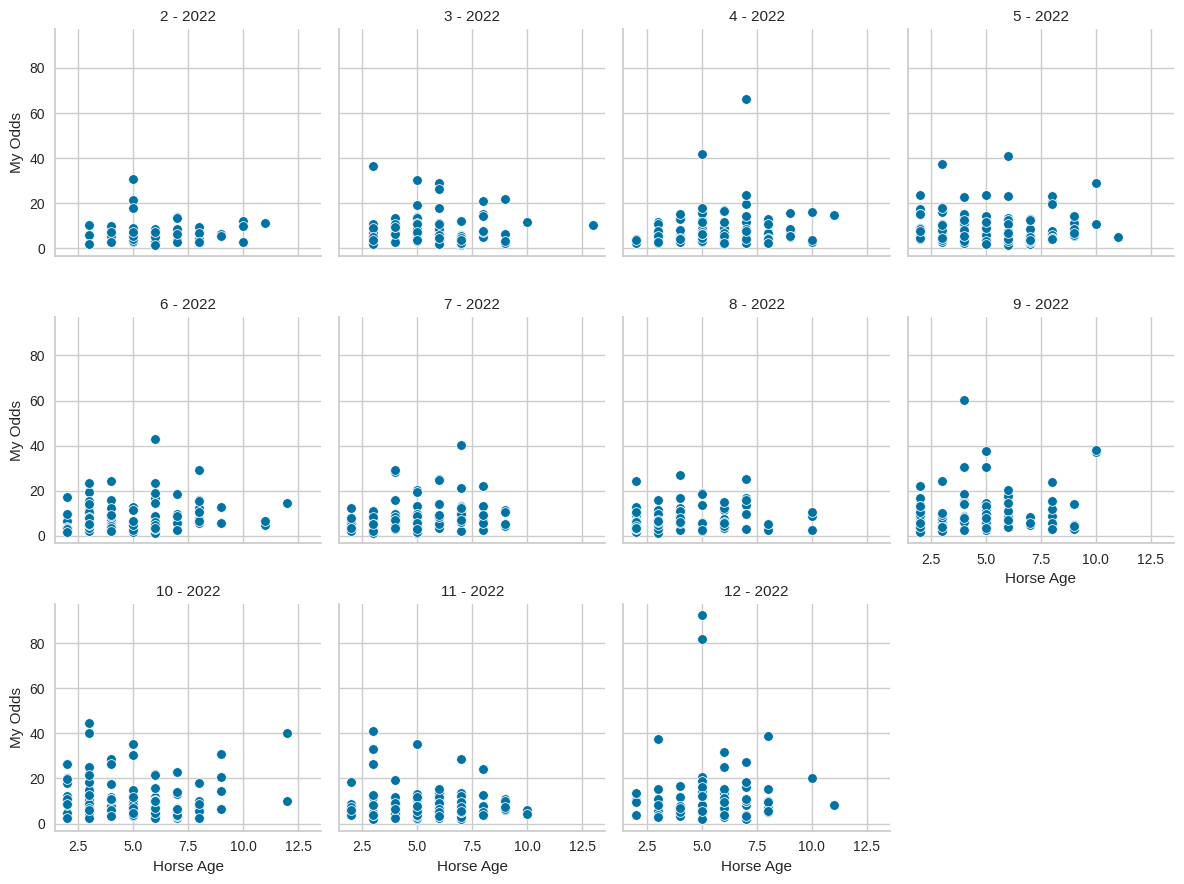

In [493]:
g = sns.FacetGrid(df.query("res_win_early != -1 and year == 2022").sample(n=1000), col="month", col_wrap=4)
g.map(sns.scatterplot, "horse_age", "my_odds")

g.set_axis_labels("Horse Age", "My Odds")
g.set_titles(col_template="{col_name} - 2022")
plt.show()

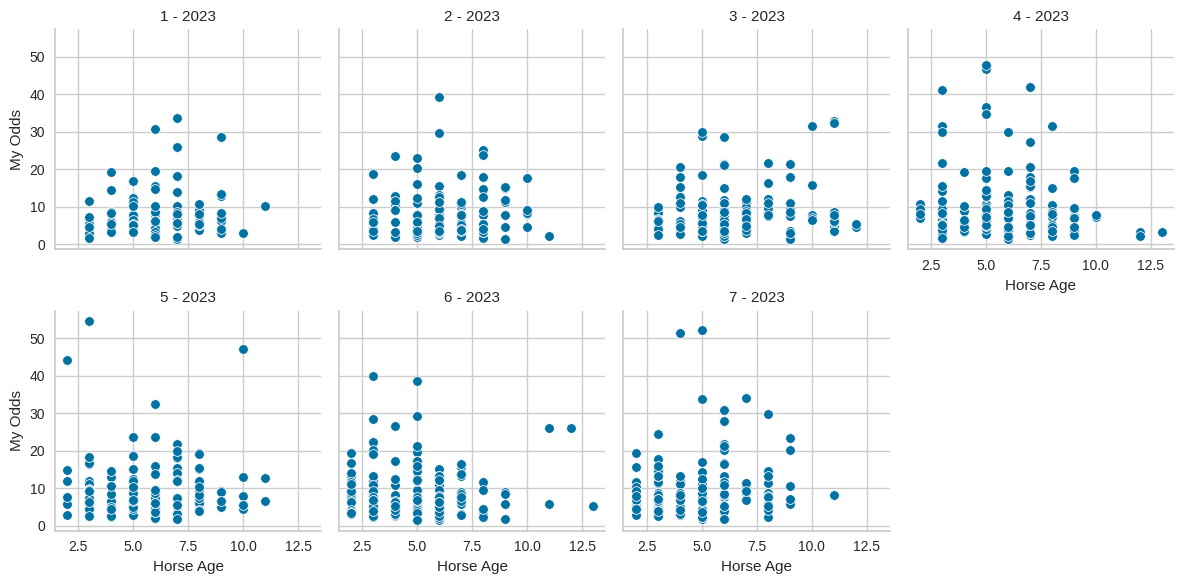

In [494]:
g = sns.FacetGrid(df.query("res_win_early != -1 and year == 2023").sample(n=1000), col="month", col_wrap=4)
g.map(sns.scatterplot, "horse_age", "my_odds")

g.set_axis_labels("Horse Age", "My Odds")
g.set_titles(col_template="{col_name} - 2023")
plt.show()

# Otimização

### Defining the problem

1. First, there's an operation to remove rows with missing data from a DataFrame `df`. This is done with `df = df.dropna()`, which means that all rows with missing values are eliminated, leaving only rows with complete data.

2. Next, a class called `ProbHourseRacing` is defined, which inherits from the `ElementwiseProblem` class. This suggests that this class is used in some optimization context.

3. The constructor `__init__` of the `ProbHourseRacing` class takes several arguments, including `stake`, `my_odds`, `res_win_sp`, `res_place_sp`, `ew_rules`, and `horse_age`. These arguments seem to be related to horse racing betting information, such as the stake made (`stake`), the odds (`my_odds`), the results of bets on winners (`res_win_sp`), the results of bets on placers (`res_place_sp`), each-way betting rules (`ew_rules`), and the age of horses (`horse_age`).

4. Inside the constructor, some variables are initialized, including `self.n_var`, which seems to be the number of variables, and other optimization-related parameters such as the number of objectives (`n_obj`), the number of constraints (`n_constr`), and lower and upper bounds (`xl` and `xu`) for decision variables.

5. The `_evaluate` function is defined to calculate the objectives and constraints of the optimization problem. It appears that this optimization problem involves two objectives: maximizing the net profit on winning bets (`f1`) and minimizing the loss in the net value of placed bets (`f2`). The constraints `g1` and `g2` are defined to ensure that the age of horses is within a certain range and that the probability of winning is greater than 25.

6. Finally, there's an explanatory comment mentioning that the optimizer's constraints will attempt to achieve their objectives as much as possible but may not be completely achieved due to the nature of the data.

In summary, this code seems to define an optimization problem related to horse racing bets, where the goal is to maximize profit on winning bets and minimize losses on placed bets, subject to some constraints related to the age of horses and the probability of winning. This optimization problem can be solved using a specific optimization technique.

1. Function f1:

   The f1 function is defined as follows:

$$
f_1(x) = -1 * \sum_{i=1}^n (bet_i * (x - 1) * \cdot res\_win\_sp_i - bet_i)
$$


   Where:
   - \(f1\) is the function you want to define.
   - \(n\) is the number of elements in \(stake\), \(res\_win\_sp\), and \(stake\).
   - \(stake_i\) is the ith element of \(stake\).
   - \(x\) is a variable.
   - \(res\_win\_sp_i\) is the ith element of \(res\_win\_sp\).

2. F2 Function:

   The f2 function is defined as follows:
   
$$
f_2(x) = \sum_{i=1}^n (bet_i * (1 - x * \cdot ew_rules_i) * \cdot res\_win\_sp_i + bet_i)
$$

   Where:

   - \(f2\) is the function you want to define.
   - \(n\) is the number of elements in \(stake\), \(ew\_rules\), and \(res\_place\_sp\).
   - \(stake_i\) is the ith element of \(stake\).
   - \(x\) is a variable.
   - \(ew\_rules_i\) is the ith element of \(ew\_rules\).
   - \(res\_place\_sp_i\) is the ith element of \(res\_place\_sp\).


In [495]:
# delete row data missing 
df = df.dropna()

class ProbHourseRacing(ElementwiseProblem):
    def __init__(self,    
        stake,
        my_odds,
        res_win_sp,
        res_place_sp,
        ew_rules,
        horse_age
    ):
        self.n_var = df.shape[0]
        self.stake = stake
        self.my_odds = my_odds
        self.res_win_sp = res_win_sp
        self.res_place_sp = res_place_sp
        self.ew_rules = ew_rules
        self.horse_age = horse_age
        
        super().__init__(
            n_var = self.n_var, 
            n_obj = 2,
            n_constr = 2,
            xl = min(self.my_odds),
            xu = max(self.my_odds)
        )
        
    def _evaluate(self, x, out, *args, **kwargs):        
        # maximizes the winner's net profit in betting
        f1 = -1 * sum(self.stake * (x - 1) * self.res_win_sp - self.stake) 
        
        # minimizing the loss of the net value of bet placements
        f2 = sum(self.stake * (1 -  x * self.ew_rules) * self.res_place_sp + self.stake)
        
            
        '''
        As mentioned in the analysis above, the horses that have the highest probability of winning are horses aged between 5 and 11 years. 
        Therefore, we create the restriction that allows choosing the maximum and minimum age of the horses
        '''
        g1 = np.all((self.horse_age > 5) & (self.horse_age < 11)) 
        
        # Restriction to get probability of victory greater than 25
        g2 = np.all(x > 30)

        out['F'] = [f1, f2]
        out['G'] = [g1, g2]
        
'''
The optimizer's restrictions will try to achieve their objective as much as possible, in some cases
will not achieve due to the nature of the data but will optimize to a point of approaching
'''        

"\nThe optimizer's restrictions will try to achieve their objective as much as possible, in some cases\nwill not achieve due to the nature of the data but will optimize to a point of approaching\n"

- Executar o NSGA-II

**NSGA-II (Non-dominated Sorting Genetic Algorithm II)** is a multi-objective optimization algorithm based on genetic algorithms. It is designed to solve optimization problems that involve optimizing multiple objectives, i.e., situations where you want to find a set of solutions that are optimal with respect to various goals or criteria, and these criteria may be in conflict with each other.

Here are the key concepts and features of NSGA-II:

1. **Multi-objective Optimization**: NSGA-II is used when there is more than one objective to be optimized. For example, in engineering, you may want to optimize a design to minimize costs and maximize efficiency, and these two objectives may conflict.

2. **Non-dominated Sorting**: A fundamental feature of NSGA-II is the non-dominated sorting of solutions. This means that it not only seeks solutions that are good with respect to a single objective but also looks for solutions that are not dominated by any other solution in terms of all objectives.

3. **Selection Based on Pareto Front**: NSGA-II uses the idea of the "Pareto Front," which is a set of non-dominated solutions. It performs parent selection from this front, ensuring a diversity of solutions that are good in different aspects.

4. **Genetic Operators**: Like other genetic algorithms, NSGA-II uses operators such as crossover and mutation to generate new solutions from existing ones.

5. **Elitism**: NSGA-II incorporates elitism to ensure that the best solutions are always preserved in subsequent generations.

6. **Population**: The algorithm operates on a population of candidate solutions and evolves this population over several generations.

7. **Convergence**: NSGA-II is designed to converge toward the true Pareto Front, where it is not possible to improve one objective without worsening another.

8. **Configurable Parameters**: The algorithm has various configurable parameters, such as population size, crossover rate, mutation rate, among others, which can be adjusted according to the specific problem.

NSGA-II is widely used in various disciplines, including engineering, finance, urban planning, and product design, whenever there is a need to find optimal solutions with respect to multiple objectives that may be in conflict. It is a powerful tool for dealing with complex multi-objective optimization problems.

In [496]:
problem = ProbHourseRacing(
    df["stake"].to_numpy(),
    df["my_odds"].to_numpy(),
    df["res_win_sp"].to_numpy(),
    df["res_place_sp"].to_numpy(),
    df["ew_rules"].to_numpy(),
    df["horse_age"].to_numpy(),
) 

nsga2 = NSGA2(
    pop_size = 100, # Number of population
    n_offsprings = 100, # Number of offspring
    eliminate_duplicates=True #  meaning duplicate individuals in the population should be removed
)

res_nsga2 = minimize(
    problem,
    nsga2,
    get_termination("n_gen", 100), # generation limit for the algorithm to generate solutions
    seed=1,
    verbose=True
)

res_x = res_nsga2.X   
res_f = res_nsga2.F

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      2 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      200 |     12 |  0.000000E+00 |  0.000000E+00 |  0.4200902921 |         ideal
     3 |      300 |     24 |  0.000000E+00 |  0.000000E+00 |  0.1870672576 |         ideal
     4 |      400 |     34 |  0.000000E+00 |  0.000000E+00 |  0.1264010348 |         ideal
     5 |      500 |     34 |  0.000000E+00 |  0.000000E+00 |  0.0748084213 |         ideal
     6 |      600 |     38 |  0.000000E+00 |  0.000000E+00 |  0.1430774513 |         ideal
     7 |      700 |     42 |  0.000000E+00 |  0.000000E+00 |  0.0061343493 |         ideal
     8 |      800 |     51 |  0.000000E+00 |  0.000000E+00 |  0.0647160281 |         ideal
     9 |      900 |     54 |  0.000000E+00 |  0.000000E+00 |  0.0740407674 |         ideal
    10 |     1000 |     59 |  0.000000E+00 |  0.000000E+00 |  0.0498039152 |         ideal

## Optimization Assessment

- Pareto Front 

The Pareto chart, also known as the Pareto front or Pareto front, is a graphical representation that shows the relationship between multiple objectives in multi-objective optimization problems. It highlights non-dominated solutions in a search space, where it's not possible to improve one objective without worsening another. The evaluation of the Pareto chart involves analyzing the following characteristics.


Notice that Pareto was formed in a very pleasant way and that f2 increases while f1 decreases, which is great for our case and shows that our solutions are great to use in future bets and obtain profits

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


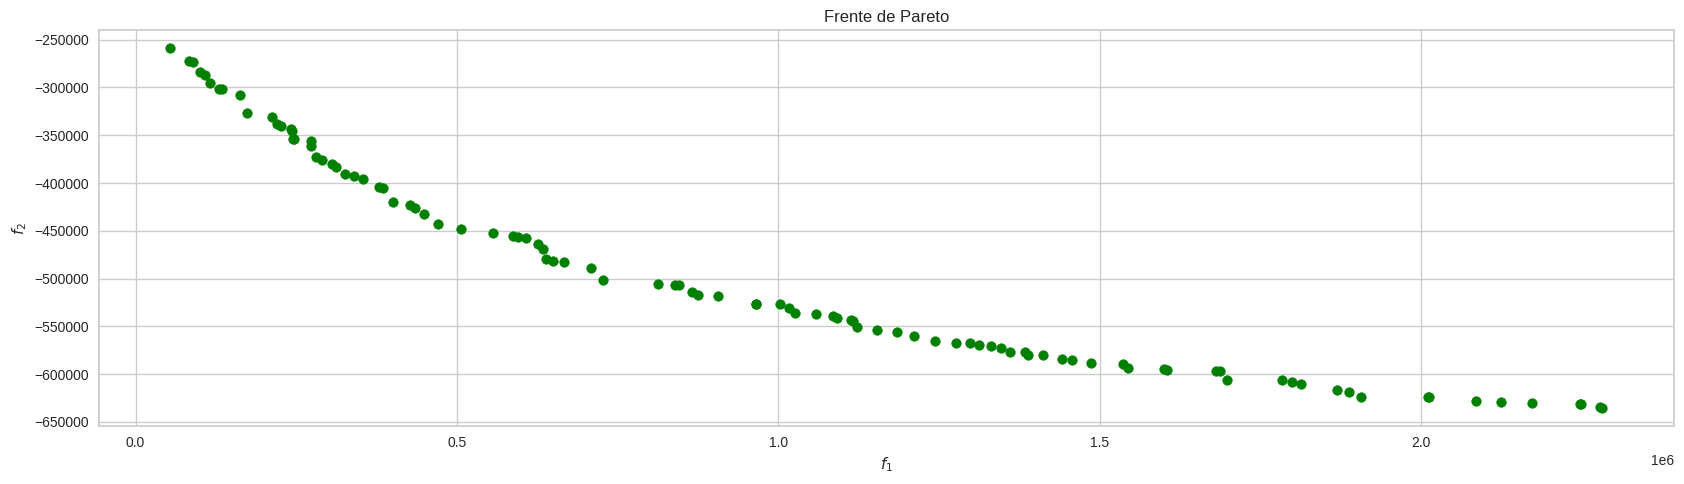

In [520]:
fig, ax = plt.subplots(figsize=[17, 5], dpi=100)

ax.scatter(res_f[:,0], res_f[:,1], color="green")
ax.set_title("Frente de Pareto")
ax.set_ylabel("$f_2$")
ax.set_xlabel("$f_1$")
ax.legend()
fig.tight_layout()

## Optimal Solutions

In [521]:
# Use non-dominated sorting to find all efficient solutions
nds = NonDominatedSorting()

# Now, nds contains the indices of efficient solutions
efficient_solutions_indices = nds.do(res_f, n_stop_if_ranked=len(res_f))

# Horses corresponding to efficient solutions
efficient_horses = df.iloc[efficient_solutions_indices[0]]

- Number of optimal solutions by horse age

In [522]:
efficient_horses.horse_age.value_counts()

horse_age
9.0     27
10.0    24
8.0     21
7.0     11
6.0      8
11.0     4
12.0     2
14.0     1
13.0     1
5.0      1
Name: count, dtype: int64

- Probability of winning for ages 8 to 10 

In [523]:
efficient_horses.query("horse_age == 8")["my_odds"]

109    35.71
140    17.85
146    28.79
148    31.63
166    67.01
191    27.53
201     9.70
204    19.35
213    30.73
217    58.76
256    17.15
268    25.23
270    28.94
275    38.19
286    49.13
288    50.16
303    98.97
336     9.59
354     5.28
356     7.26
380     6.35
Name: my_odds, dtype: float64

In [524]:
efficient_horses.query("horse_age == 9")["my_odds"]

141     22.19
143     24.77
149     32.03
150     33.40
151     33.72
155     42.18
165     66.36
192     31.60
195     42.00
197     79.44
198    172.94
211     29.59
216     51.02
249     10.71
258     18.18
263     28.49
266     21.64
267     21.67
269     26.15
274     38.01
278     41.11
287     49.92
292     61.24
295     64.17
302     89.72
334      8.26
362     17.79
Name: my_odds, dtype: float64

In [525]:
efficient_horses.query("horse_age == 10")["my_odds"]

98      16.42
137      8.97
147     29.39
152     33.83
153     39.64
158     52.91
159     54.22
205     21.63
209     25.36
253     14.88
261     26.20
273     34.76
276     39.04
281     44.92
282     46.47
283     48.16
289     51.10
296     68.29
300     75.85
301     75.88
304    102.97
306    140.10
337     13.08
359     11.88
Name: my_odds, dtype: float64

- Optimal solution times

In [535]:
efficient_horses.race_time.unique()

array(['13:45', '16:05', '17:15', '16:15', '17:50', '19:35', '20:10',
       '17:28'], dtype=object)

## Filter of race time

- 13:45

In [536]:
efficient_horses.query("race_time ==  '13:45' ")

,race_id,runner_id,meeting_date,course,race_time,race_timestamp,name,b_rank,m_rank,rank_diff,...,res_place_sp,res_win_bf,res_place_bf,prediction_error,gross_profit,net_profit,year,quarter,month,race_period
95,1113082,2841208,2022-04-08,aintree,13:45,45:00.0,peking rose,4.0,7.0,3.0,...,-1.0,-1.0,-1.00,16.17,16.0,0.0,2022,2,4,11:20-15:30
96,1113082,3238890,2022-04-08,aintree,13:45,45:00.0,cobblers dream,5.0,3.0,-2.0,...,-1.0,-1.0,-1.00,16.59,11.0,0.0,2022,2,4,11:20-15:30
98,1113082,2057585,2022-04-08,aintree,13:45,45:00.0,paddys motorbike,7.0,11.0,4.0,...,-1.0,-1.0,-1.00,17.42,31.0,0.0,2022,2,4,11:20-15:30
105,1113082,2408398,2022-04-08,aintree,13:45,45:00.0,navajo pass,14.0,14.0,0.0,...,6.6,-1.0,7.00,29.64,41.0,0.0,2022,2,4,11:20-15:30
107,1113082,2443360,2022-04-08,aintree,13:45,45:00.0,garry clermont,16.0,13.0,-3.0,...,5.0,-1.0,5.40,33.94,39.0,0.0,2022,2,4,11:20-15:30
108,1113082,2460073,2022-04-08,aintree,13:45,45:00.0,tronador,17.0,10.0,-7.0,...,-1.0,-1.0,-1.00,34.35,29.0,0.0,2022,2,4,11:20-15:30
109,1113082,2458438,2022-04-08,aintree,13:45,45:00.0,politesse,18.0,9.0,-9.0,...,-1.0,-1.0,-1.00,36.71,28.0,0.0,2022,2,4,11:20-15:30
112,1113082,2475968,2022-04-08,aintree,13:45,45:00.0,rockadenn,21.0,21.0,0.0,...,-1.0,-1.0,-1.00,39.79,211.0,0.0,2022,2,4,11:20-15:30
201,1113425,2438441,2022-04-09,aintree,13:45,45:00.0,winter fog,3.0,1.0,-2.0,...,-1.0,-1.0,-1.00,10.70,8.2,0.0,2022,2,4,11:20-15:30
203,1113425,2465865,2022-04-09,aintree,13:45,45:00.0,saint doroux,5.0,16.5,11.5,...,-1.0,-1.0,-1.00,17.80,49.0,0.0,2022,2,4,11:20-15:30


- 16:05

In [537]:
efficient_horses.query("race_time ==  '13:45' ")

,race_id,runner_id,meeting_date,course,race_time,race_timestamp,name,b_rank,m_rank,rank_diff,...,res_place_sp,res_win_bf,res_place_bf,prediction_error,gross_profit,net_profit,year,quarter,month,race_period
95,1113082,2841208,2022-04-08,aintree,13:45,45:00.0,peking rose,4.0,7.0,3.0,...,-1.0,-1.0,-1.00,16.17,16.0,0.0,2022,2,4,11:20-15:30
96,1113082,3238890,2022-04-08,aintree,13:45,45:00.0,cobblers dream,5.0,3.0,-2.0,...,-1.0,-1.0,-1.00,16.59,11.0,0.0,2022,2,4,11:20-15:30
98,1113082,2057585,2022-04-08,aintree,13:45,45:00.0,paddys motorbike,7.0,11.0,4.0,...,-1.0,-1.0,-1.00,17.42,31.0,0.0,2022,2,4,11:20-15:30
105,1113082,2408398,2022-04-08,aintree,13:45,45:00.0,navajo pass,14.0,14.0,0.0,...,6.6,-1.0,7.00,29.64,41.0,0.0,2022,2,4,11:20-15:30
107,1113082,2443360,2022-04-08,aintree,13:45,45:00.0,garry clermont,16.0,13.0,-3.0,...,5.0,-1.0,5.40,33.94,39.0,0.0,2022,2,4,11:20-15:30
108,1113082,2460073,2022-04-08,aintree,13:45,45:00.0,tronador,17.0,10.0,-7.0,...,-1.0,-1.0,-1.00,34.35,29.0,0.0,2022,2,4,11:20-15:30
109,1113082,2458438,2022-04-08,aintree,13:45,45:00.0,politesse,18.0,9.0,-9.0,...,-1.0,-1.0,-1.00,36.71,28.0,0.0,2022,2,4,11:20-15:30
112,1113082,2475968,2022-04-08,aintree,13:45,45:00.0,rockadenn,21.0,21.0,0.0,...,-1.0,-1.0,-1.00,39.79,211.0,0.0,2022,2,4,11:20-15:30
201,1113425,2438441,2022-04-09,aintree,13:45,45:00.0,winter fog,3.0,1.0,-2.0,...,-1.0,-1.0,-1.00,10.70,8.2,0.0,2022,2,4,11:20-15:30
203,1113425,2465865,2022-04-09,aintree,13:45,45:00.0,saint doroux,5.0,16.5,11.5,...,-1.0,-1.0,-1.00,17.80,49.0,0.0,2022,2,4,11:20-15:30


- 16:15

In [538]:
efficient_horses.query(" race_time ==  '16:15' ")

,race_id,runner_id,meeting_date,course,race_time,race_timestamp,name,b_rank,m_rank,rank_diff,...,res_place_sp,res_win_bf,res_place_bf,prediction_error,gross_profit,net_profit,year,quarter,month,race_period
248,1113429,2677075,2022-04-09,aintree,16:15,15:00.0,killer kane,1.0,5.0,4.0,...,-1.000,-1.00,-1.00,8.41,12.0,0.0,2022,2,4,15:31-18:00
249,1113429,2272389,2022-04-09,aintree,16:15,15:00.0,cap du nord,2.0,6.0,4.0,...,1.875,-1.00,1.38,11.71,13.5,0.0,2022,2,4,15:31-18:00
250,1113429,2443347,2022-04-09,aintree,16:15,15:00.0,tea clipper,3.0,2.0,-1.0,...,-1.000,-1.00,-1.00,15.13,8.4,0.0,2022,2,4,15:31-18:00
252,1113429,2535148,2022-04-09,aintree,16:15,15:00.0,oscar elite,5.0,3.0,-2.0,...,1.500,-1.00,1.05,15.50,10.8,0.0,2022,2,4,15:31-18:00
253,1113429,2267847,2022-04-09,aintree,16:15,15:00.0,sam brown,6.0,13.5,7.5,...,7.000,33.34,4.50,-13.12,27.0,27.0,2022,2,4,15:31-18:00
256,1113429,2438264,2022-04-09,aintree,16:15,15:00.0,exelerator express,9.0,15.0,6.0,...,-1.000,-1.00,-1.00,18.15,61.0,0.0,2022,2,4,15:31-18:00
257,1113429,2450295,2022-04-09,aintree,16:15,15:00.0,adrimel,10.0,9.0,-1.0,...,6.250,-1.00,4.25,18.81,31.0,0.0,2022,2,4,15:31-18:00
258,1113429,2236887,2022-04-09,aintree,16:15,15:00.0,didero vallis,11.0,13.5,2.5,...,20.000,-1.00,9.53,19.18,56.0,0.0,2022,2,4,15:31-18:00
260,1113429,2098274,2022-04-09,aintree,16:15,15:00.0,wishing and hoping,13.0,10.0,-3.0,...,-1.000,-1.00,-1.00,24.65,35.0,0.0,2022,2,4,15:31-18:00
261,1113429,2215225,2022-04-09,aintree,16:15,15:00.0,espoir de teillee,14.0,16.0,2.0,...,20.000,-1.00,11.50,27.20,101.0,0.0,2022,2,4,15:31-18:00


- 17:15

In [539]:
efficient_horses.query("race_time ==  '17:15' ")

,race_id,runner_id,meeting_date,course,race_time,race_timestamp,name,b_rank,m_rank,rank_diff,...,res_place_sp,res_win_bf,res_place_bf,prediction_error,gross_profit,net_profit,year,quarter,month,race_period
182,1113087,2467664,2022-04-08,aintree,17:15,15:00.0,whizz kid,2.0,1.0,-1.0,...,-1.0,-1.0,-1.00,8.88,6.8,0.0,2022,2,4,15:31-18:00
191,1113087,2277993,2022-04-08,aintree,17:15,15:00.0,alberts back,10.0,11.0,1.0,...,6.6,-1.0,5.20,28.53,41.0,0.0,2022,2,4,15:31-18:00
192,1113087,2326083,2022-04-08,aintree,17:15,15:00.0,thibault,11.0,14.0,3.0,...,-1.0,-1.0,-1.00,32.60,66.0,0.0,2022,2,4,15:31-18:00
195,1113087,2281174,2022-04-08,aintree,17:15,15:00.0,due reward,14.0,15.0,1.0,...,-1.0,-1.0,-1.00,43.00,111.0,0.0,2022,2,4,15:31-18:00
197,1113087,2173162,2022-04-08,aintree,17:15,15:00.0,mandarin monarch,16.0,12.5,-3.5,...,6.6,-1.0,9.84,80.44,51.0,0.0,2022,2,4,15:31-18:00
198,1113087,2232668,2022-04-08,aintree,17:15,15:00.0,antey,17.0,16.0,-1.0,...,30.0,-1.0,46.12,173.94,181.0,0.0,2022,2,4,15:31-18:00
266,1109962,2200879,2022-04-09,aintree,17:15,15:00.0,burrows saint,3.0,11.0,8.0,...,6.6,-1.0,10.49,22.64,33.0,0.0,2022,2,4,15:31-18:00
267,1109962,2254740,2022-04-09,aintree,17:15,15:00.0,delta work,4.0,3.5,-0.5,...,2.0,-1.0,4.04,22.67,15.5,0.0,2022,2,4,15:31-18:00
268,1109962,2355175,2022-04-09,aintree,17:15,15:00.0,fiddlerontheroof,5.0,7.5,2.5,...,-1.0,-1.0,-1.00,26.23,22.0,0.0,2022,2,4,15:31-18:00
269,1109962,2323510,2022-04-09,aintree,17:15,15:00.0,two for gold,6.0,18.0,12.0,...,6.6,-1.0,10.00,27.15,51.0,0.0,2022,2,4,15:31-18:00


# Segmentation: Discovering groups of horses in the optimal solutions

- Aplicar Min Max Scaler

Data Scaling is a data preprocessing step for numerical features. Many machine learning algorithms like Gradient descent methods, KNN algorithm, linear and logistic regression, etc. require data scaling to produce good results. MinMax Scaler shrinks the data within the given range, usually of 0 to 1. It transforms data by scaling features to a given range. It scales the values to a specific value range without changing the shape of the original distribution.

In [540]:
numerical_features = efficient_horses.select_dtypes(include=['number']).drop(columns=["race_id", "runner_id"])

In [554]:
scaler = MinMaxScaler()
numerical_features = scaler.fit_transform(numerical_features)

- PCA

We cannot visualize anything more than three attributes in 3D scenarios and in the real world, there can be hundreds of attributes.
So how can we visualize the clustering results?

Well, this can be done by applying principal component analysis (PCA) on the dataset to reduce its dimension to just two while still preserving the information. And then clustering can be applied to this transformed dataset and then visualized in a 2D graph. Furthermore, PCA can also help avoid the curse of dimensionality.

In [556]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(numerical_features)
df_pca = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
df_pca.head()

,principal component 1,principal component 2
0,-0.658821,0.093619
1,-0.772792,-0.054462
2,-0.420118,0.255035
3,-0.201158,0.388074
4,-0.240473,0.271416


- Metodo do cotovelo

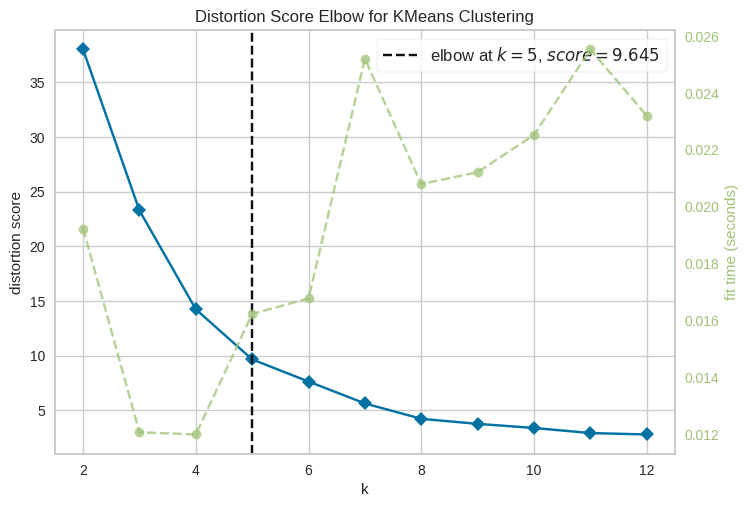

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [557]:
visualizer = KElbowVisualizer(KMeans(), k=(2,13))
visualizer.fit(df_pca)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [558]:
K=range(2,13)
wss = []

for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_pca)
    wss_iter = kmeans.inertia_
    print(f"k = {k} -> {wss_iter}")

k = 2 -> 38.022800180762914
k = 3 -> 23.281511849787154
k = 4 -> 14.232009836139838
k = 5 -> 9.64539563773069
k = 6 -> 7.619276182119576
k = 7 -> 5.616776377262847
k = 8 -> 4.204840883898161
k = 9 -> 3.7628217331473683
k = 10 -> 3.3707127580739753
k = 11 -> 2.915059805877066
k = 12 -> 2.6665584081010056


- The Silhouette Method

The silhouette value measures the similarity of a data point within its cluster. It has a range between +1 and -1 and the higher values denote a good clustering.

Below we calculate the Silhouette Score for k=2 to 12 and it can be seen that the maximum value is for k=5. This is in line with the elbow method.



In [559]:
for k in range(2,13):
    label = KMeans(n_clusters=k, random_state=200).fit(df_pca).labels_
    score = silhouette_score(df_pca, label, metric="euclidean", sample_size=1000, random_state=200)
    print(f"Silhouette score for cluster {k} is {score}")

Silhouette score for cluster 2 is 0.5275131166847925
Silhouette score for cluster 3 is 0.5369769053761703
Silhouette score for cluster 4 is 0.4962510701053795
Silhouette score for cluster 5 is 0.5120814293162598
Silhouette score for cluster 6 is 0.5159827415318404
Silhouette score for cluster 7 is 0.48952688331068217
Silhouette score for cluster 8 is 0.49181005125499716
Silhouette score for cluster 9 is 0.4243423581116559
Silhouette score for cluster 10 is 0.41785284276923157
Silhouette score for cluster 11 is 0.4328808348169171
Silhouette score for cluster 12 is 0.4163213485342734


 - Aplicantion K-means

In [561]:
kmeans = KMeans(n_clusters=8 ,init="k-means++")
kmeans.fit(df_pca)
efficient_horses['clusters'] = kmeans.labels_

- Visualizar os grupos

In [562]:
g = px.scatter(
    x = df_pca["principal component 1"].values,
    y = df_pca["principal component 2"].values,
    color = efficient_horses['clusters'].values,
    color_continuous_scale = "Turbo"  
)
g.show()

Now you can analyze each cluster and choose horses that make the most sense to bet on

In [564]:
efficient_horses.query("clusters == 0")

,race_id,runner_id,meeting_date,course,race_time,race_timestamp,name,b_rank,m_rank,rank_diff,...,res_win_bf,res_place_bf,prediction_error,gross_profit,net_profit,year,quarter,month,race_period,clusters
112,1113082,2475968,2022-04-08,aintree,13:45,45:00.0,rockadenn,21.0,21.0,0.0,...,-1.0,-1.00,39.79,211.0,0.0,2022,2,4,11:20-15:30,0
151,1109960,2243820,2022-04-08,aintree,16:05,05:00.0,annamix,15.0,26.0,11.0,...,-1.0,15.44,34.72,76.0,0.0,2022,2,4,15:31-18:00,0
153,1109960,2207599,2022-04-08,aintree,16:05,05:00.0,mister whitaker,17.0,21.5,4.5,...,-1.0,26.40,40.64,56.0,0.0,2022,2,4,15:31-18:00,0
158,1109960,2285661,2022-04-08,aintree,16:05,05:00.0,windsor avenue,22.0,27.5,5.5,...,-1.0,11.00,53.91,86.0,0.0,2022,2,4,15:31-18:00,0
160,1109960,1692343,2022-04-08,aintree,16:05,05:00.0,regal encore,24.0,29.0,5.0,...,-1.0,-1.00,56.23,101.0,0.0,2022,2,4,15:31-18:00,0
217,1113425,2424288,2022-04-09,aintree,13:45,45:00.0,the cob,19.0,19.0,0.0,...,-1.0,13.21,59.76,61.0,0.0,2022,2,4,11:20-15:30,0
258,1113429,2236887,2022-04-09,aintree,16:15,15:00.0,didero vallis,11.0,13.5,2.5,...,-1.0,9.53,19.18,56.0,0.0,2022,2,4,15:31-18:00,0
261,1113429,2215225,2022-04-09,aintree,16:15,15:00.0,espoir de teillee,14.0,16.0,2.0,...,-1.0,11.50,27.20,101.0,0.0,2022,2,4,15:31-18:00,0


In [565]:
efficient_horses.query("clusters == 1")

,race_id,runner_id,meeting_date,course,race_time,race_timestamp,name,b_rank,m_rank,rank_diff,...,res_win_bf,res_place_bf,prediction_error,gross_profit,net_profit,year,quarter,month,race_period,clusters
95,1113082,2841208,2022-04-08,aintree,13:45,45:00.0,peking rose,4.0,7.0,3.0,...,-1.00,-1.00,16.17,16.0,0.0,2022,2,4,11:20-15:30,1
96,1113082,3238890,2022-04-08,aintree,13:45,45:00.0,cobblers dream,5.0,3.0,-2.0,...,-1.00,-1.00,16.59,11.0,0.0,2022,2,4,11:20-15:30,1
108,1113082,2460073,2022-04-08,aintree,13:45,45:00.0,tronador,17.0,10.0,-7.0,...,-1.00,-1.00,34.35,29.0,0.0,2022,2,4,11:20-15:30,1
109,1113082,2458438,2022-04-08,aintree,13:45,45:00.0,politesse,18.0,9.0,-9.0,...,-1.00,-1.00,36.71,28.0,0.0,2022,2,4,11:20-15:30,1
137,1109960,2269114,2022-04-08,aintree,16:05,05:00.0,royal rendezvous,1.0,3.0,2.0,...,-1.00,2.43,9.97,13.0,0.0,2022,2,4,15:31-18:00,1
147,1109960,2213424,2022-04-08,aintree,16:05,05:00.0,spiritofthegames,11.0,7.0,-4.0,...,-1.00,-1.00,30.39,19.0,0.0,2022,2,4,15:31-18:00,1
148,1109960,2424673,2022-04-08,aintree,16:05,05:00.0,killer clown,12.0,8.5,-3.5,...,-1.00,-1.00,32.63,25.0,0.0,2022,2,4,15:31-18:00,1
150,1109960,2290233,2022-04-08,aintree,16:05,05:00.0,mac tottie,14.0,2.0,-12.0,...,12.55,3.30,25.40,3.5,3.5,2022,2,4,15:31-18:00,1
201,1113425,2438441,2022-04-09,aintree,13:45,45:00.0,winter fog,3.0,1.0,-2.0,...,-1.00,-1.00,10.70,8.2,0.0,2022,2,4,11:20-15:30,1
205,1113425,2255376,2022-04-09,aintree,13:45,45:00.0,if the cap fits,7.0,7.0,0.0,...,-1.00,-1.00,22.63,18.5,0.0,2022,2,4,11:20-15:30,1


In [566]:
efficient_horses.query("clusters== 2")

,race_id,runner_id,meeting_date,course,race_time,race_timestamp,name,b_rank,m_rank,rank_diff,...,res_win_bf,res_place_bf,prediction_error,gross_profit,net_profit,year,quarter,month,race_period,clusters
266,1109962,2200879,2022-04-09,aintree,17:15,15:00.0,burrows saint,3.0,11.0,8.0,...,-1.0,10.49,22.64,33.0,0.0,2022,2,4,15:31-18:00,2
269,1109962,2323510,2022-04-09,aintree,17:15,15:00.0,two for gold,6.0,18.0,12.0,...,-1.0,10.00,27.15,51.0,0.0,2022,2,4,15:31-18:00,2
277,1109962,2522188,2022-04-09,aintree,17:15,15:00.0,noble yeats,14.0,25.0,11.0,...,28.1,18.50,-9.83,30.0,30.0,2022,2,4,15:31-18:00,2
278,1109962,2263568,2022-04-09,aintree,17:15,15:00.0,discorama,15.0,18.0,3.0,...,-1.0,8.48,42.11,51.0,0.0,2022,2,4,15:31-18:00,2
281,1109962,2255544,2022-04-09,aintree,17:15,15:00.0,lostintranslation,18.0,27.0,9.0,...,-1.0,-1.00,45.92,91.0,0.0,2022,2,4,15:31-18:00,2
282,1109962,2202630,2022-04-09,aintree,17:15,15:00.0,samcro,19.0,33.5,14.5,...,-1.0,-1.00,47.47,141.0,0.0,2022,2,4,15:31-18:00,2
283,1109962,2204098,2022-04-09,aintree,17:15,15:00.0,kildisart,20.0,23.0,3.0,...,-1.0,12.00,49.16,66.0,0.0,2022,2,4,15:31-18:00,2
286,1109962,2418131,2022-04-09,aintree,17:15,15:00.0,mount ida,23.0,29.0,6.0,...,-1.0,14.49,50.13,101.0,0.0,2022,2,4,15:31-18:00,2
290,1109962,2428678,2022-04-09,aintree,17:15,15:00.0,coko beach,27.0,31.5,4.5,...,-1.0,-1.00,52.45,131.0,0.0,2022,2,4,15:31-18:00,2
291,1109962,1958701,2022-04-09,aintree,17:15,15:00.0,blaklion,28.0,28.0,0.0,...,-1.0,-1.00,54.68,96.0,0.0,2022,2,4,15:31-18:00,2


In [567]:
efficient_horses.query("clusters == 3")

,race_id,runner_id,meeting_date,course,race_time,race_timestamp,name,b_rank,m_rank,rank_diff,...,res_win_bf,res_place_bf,prediction_error,gross_profit,net_profit,year,quarter,month,race_period,clusters
274,1109962,2328518,2022-04-09,aintree,17:15,15:00.0,agusta gold,11.0,33.5,22.5,...,-1.0,17.94,39.01,141.0,0.0,2022,2,4,15:31-18:00,3
276,1109962,2210030,2022-04-09,aintree,17:15,15:00.0,top ville ben,13.0,30.0,17.0,...,-1.0,25.70,40.04,121.0,0.0,2022,2,4,15:31-18:00,3
287,1109962,2360912,2022-04-09,aintree,17:15,15:00.0,deise aba,24.0,26.0,2.0,...,-1.0,27.92,50.92,86.0,0.0,2022,2,4,15:31-18:00,3
289,1109962,2175653,2022-04-09,aintree,17:15,15:00.0,class conti,26.0,39.0,13.0,...,-1.0,-1.00,52.10,251.0,0.0,2022,2,4,15:31-18:00,3
295,1109962,2324084,2022-04-09,aintree,17:15,15:00.0,domaine de lisle,32.0,37.0,5.0,...,-1.0,25.00,65.17,181.0,0.0,2022,2,4,15:31-18:00,3
299,1109962,2117841,2022-04-09,aintree,17:15,15:00.0,brahma bull,37.0,35.5,-1.5,...,-1.0,31.95,76.74,161.0,0.0,2022,2,4,15:31-18:00,3
300,1109962,2159509,2022-04-09,aintree,17:15,15:00.0,poker party,38.0,38.0,0.0,...,-1.0,24.28,76.85,191.0,0.0,2022,2,4,15:31-18:00,3
304,1109962,2118589,2022-04-09,aintree,17:15,15:00.0,romain de senam,42.0,40.0,-2.0,...,-1.0,-1.00,103.97,311.0,0.0,2022,2,4,15:31-18:00,3
305,1109962,2104005,2022-04-09,aintree,17:15,15:00.0,anibale fly,43.0,31.5,-11.5,...,-1.0,20.00,122.36,131.0,0.0,2022,2,4,15:31-18:00,3


In [568]:
efficient_horses.query("clusters == 4")

,race_id,runner_id,meeting_date,course,race_time,race_timestamp,name,b_rank,m_rank,rank_diff,...,res_win_bf,res_place_bf,prediction_error,gross_profit,net_profit,year,quarter,month,race_period,clusters
267,1109962,2254740,2022-04-09,aintree,17:15,15:00.0,delta work,4.0,3.5,-0.5,...,-1.0,4.04,22.67,15.5,0.0,2022,2,4,15:31-18:00,4
268,1109962,2355175,2022-04-09,aintree,17:15,15:00.0,fiddlerontheroof,5.0,7.5,2.5,...,-1.0,-1.00,26.23,22.0,0.0,2022,2,4,15:31-18:00,4
270,1109962,2360932,2022-04-09,aintree,17:15,15:00.0,run wild fred,7.0,9.0,2.0,...,-1.0,3.02,29.94,24.0,0.0,2022,2,4,15:31-18:00,4
273,1109962,2258290,2022-04-09,aintree,17:15,15:00.0,any second now,10.0,3.5,-6.5,...,-1.0,2.91,35.76,15.5,0.0,2022,2,4,15:31-18:00,4
275,1109962,2446553,2022-04-09,aintree,17:15,15:00.0,escaria ten,12.0,10.0,-2.0,...,-1.0,-1.00,39.19,26.0,0.0,2022,2,4,15:31-18:00,4
288,1109962,2436968,2022-04-09,aintree,17:15,15:00.0,longhouse poet,25.0,5.5,-19.5,...,-1.0,-1.00,51.16,21.0,0.0,2022,2,4,15:31-18:00,4
292,1109962,2281195,2022-04-09,aintree,17:15,15:00.0,minella times,29.0,1.0,-28.0,...,-1.0,5.09,62.24,13.0,0.0,2022,2,4,15:31-18:00,4
303,1109962,2440064,2022-04-09,aintree,17:15,15:00.0,enjoy dallen,41.0,5.5,-35.5,...,-1.0,5.87,99.97,21.0,0.0,2022,2,4,15:31-18:00,4


In [569]:
efficient_horses.query("clusters == 5")

,race_id,runner_id,meeting_date,course,race_time,race_timestamp,name,b_rank,m_rank,rank_diff,...,res_win_bf,res_place_bf,prediction_error,gross_profit,net_profit,year,quarter,month,race_period,clusters
182,1113087,2467664,2022-04-08,aintree,17:15,15:00.0,whizz kid,2.0,1.0,-1.0,...,-1.00,-1.00,8.88,6.80,0.00,2022,2,4,15:31-18:00,5
250,1113429,2443347,2022-04-09,aintree,16:15,15:00.0,tea clipper,3.0,2.0,-1.0,...,-1.00,-1.00,15.13,8.40,0.00,2022,2,4,15:31-18:00,5
334,1122995,2263196,2022-05-13,aintree,17:50,50:00.0,destrier,4.0,5.0,1.0,...,7.20,1.55,1.26,1.60,1.60,2022,2,5,15:31-18:00,5
336,1122995,2416380,2022-05-13,aintree,17:50,50:00.0,dublin four,6.0,1.0,-5.0,...,-1.00,-1.00,10.59,5.00,0.00,2022,2,5,15:31-18:00,5
354,1122998,2438264,2022-05-13,aintree,19:35,35:00.0,exelerator express,1.0,2.0,1.0,...,2.71,0.70,2.53,2.05,2.05,2022,2,5,18:00-21:00,5
355,1122998,2453013,2022-05-13,aintree,19:35,35:00.0,sail away,2.0,3.0,1.0,...,-1.00,-1.00,6.99,7.40,0.00,2022,2,5,18:00-21:00,5
356,1122998,2329395,2022-05-13,aintree,19:35,35:00.0,empire de maulde,3.0,1.0,-2.0,...,-1.00,-1.00,8.26,5.30,0.00,2022,2,5,18:00-21:00,5
367,1122999,2412805,2022-05-13,aintree,20:10,10:00.0,persuer,4.0,3.0,-1.0,...,-1.00,-1.00,6.47,4.80,0.00,2022,2,5,18:00-21:00,5
379,1131340,3798819,2022-06-10,aintree,17:28,28:00.0,kerosine light,1.0,1.0,0.0,...,-1.00,-1.00,3.67,4.70,0.00,2022,2,6,15:31-18:00,5
380,1131340,2424655,2022-06-10,aintree,17:28,28:00.0,cremant,2.0,2.0,0.0,...,2.80,1.06,3.60,1.45,1.45,2022,2,6,15:31-18:00,5


In [570]:
efficient_horses.query("clusters == 6")

,race_id,runner_id,meeting_date,course,race_time,race_timestamp,name,b_rank,m_rank,rank_diff,...,res_win_bf,res_place_bf,prediction_error,gross_profit,net_profit,year,quarter,month,race_period,clusters
159,1109960,2248722,2022-04-08,aintree,16:05,05:00.0,cobolobo,23.0,30.0,7.0,...,-1.0,33.88,55.22,131.0,0.0,2022,2,4,15:31-18:00,6
198,1113087,2232668,2022-04-08,aintree,17:15,15:00.0,antey,17.0,16.0,-1.0,...,-1.0,46.12,173.94,181.0,0.0,2022,2,4,15:31-18:00,6
218,1113425,2306117,2022-04-09,aintree,13:45,45:00.0,whirling dervish,20.0,20.0,0.0,...,-1.0,46.41,71.01,131.0,0.0,2022,2,4,11:20-15:30,6
